# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the libraries you will be using for analysis

# Numerical and Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

In [4]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [7]:
filepath = "C:/Users/rohit/Desktop/python/Projects/Datasets and Dictionary-NYC"

In [11]:
# Try loading one file

df = pd.read_parquet(filepath + '/trip_records/2023-1.parquet')
df.shape

(3041714, 19)

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [18]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#  read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir(filepath + '/trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialize an empty dataframe
df = pd.DataFrame()

# Start time
start_time = datetime.now()
print(f"Process started at: {start_time}")

# Iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # File path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        monthly_data = pd.read_parquet(file_path)

        print("******************************")
        print("\n")
        print(f"Processing file: {file_name}...")
        start_time = datetime.now()
        print(f"File Processing started at: {start_time}")

        # Convert pickup datetime to datetime format (if not already)
        monthly_data["tpep_pickup_datetime"] = pd.to_datetime(monthly_data["tpep_pickup_datetime"])

        # Extract date and hour
        monthly_data["date"] = monthly_data["tpep_pickup_datetime"].dt.date
        monthly_data["hour"] = monthly_data["tpep_pickup_datetime"].dt.hour

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for selected_date in monthly_data["date"].unique():
            date_df = monthly_data[monthly_data["date"] == selected_date]  # Filter data for the day

            # Iterate through each hour of the selected date
            for hour in range(24):
                hour_df = date_df[date_df["hour"] == hour]  # Filter data for the hour
                
                # Sample 5% of the hourly data randomly (only if data is present)
                if not hour_df.empty:
                    sampled_hourly_df = hour_df.sample(frac=0.05, random_state=42)

                    # Add sampled data of this hour to the temporary dataframe
                    sampled_data = pd.concat([sampled_data, sampled_hourly_df], ignore_index=True)
        
        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data], ignore_index=True)  # We initialized this empty DF earlier
        
        print(f"Processing completed for {file_name}")
        # End time
        end_time = datetime.now()
        print(f"File processing completed at: {end_time}")
        print("\n")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

end_time = datetime.now()
print(f"Processing completed at: {end_time}")
# Calculate duration
duration = end_time - start_time
print(f"Total time taken: {duration}")
# Print the final dataset shape
print(f"Final Combined Dataset Shape: {df.shape}")

Process started at: 2025-02-24 12:05:37.085492
******************************


Processing file: 2023-1.parquet...
File Processing started at: 2025-02-24 12:05:37.608938
Processing completed for 2023-1.parquet
File processing completed at: 2025-02-24 12:05:58.533005


******************************


Processing file: 2023-10.parquet...
File Processing started at: 2025-02-24 12:05:59.294669
Processing completed for 2023-10.parquet
File processing completed at: 2025-02-24 12:06:21.726256


******************************


Processing file: 2023-11.parquet...
File Processing started at: 2025-02-24 12:06:22.625359
Processing completed for 2023-11.parquet
File processing completed at: 2025-02-24 12:06:42.813428


******************************


Processing file: 2023-12.parquet...
File Processing started at: 2025-02-24 12:06:43.545032
Processing completed for 2023-12.parquet
File processing completed at: 2025-02-24 12:07:05.683385


******************************


Processing file: 2023-2.pa

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [24]:
# Store the df in csv/parquet
# df.to_parquet('')

# Saving the data in CSV format
df.to_csv("final_combined_sampled.csv", index=False)

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [27]:
# Load the new data file

taxi_df = pd.read_csv("C:/Users/rohit/Desktop/python/Projects/Datasets and Dictionary-NYC/trip_records/final_combined_sampled.csv")


In [28]:
taxi_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4          19.24         NaN                NaN            66           107   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             2  ...      0.5        0.00           0.0   
1             1  ...      0.5        2.58           0.0   
2             2  ...      0.5        0.00           0.0   
3             2  ...      0.5        0.00           0.0   
4             0  ...      0.5        5.93           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.15                   0.0         1.25   
1                    1.0         15.48                   2.5         0.00   
2                    1.0         16.40                   2.5         0.00   
3                    1.0         11.50                   2.5         0.00   
4                    1.0         35.57                   NaN          NaN   

         date  hour Airport_fee  
0  2023-01-01     0         NaN  
1  2023-01-01     0         NaN  
2  2023-01-01     0         NaN  
3  2023-01-01     0         NaN  
4  2023-01-01     0         NaN  

[5 rows x 22 columns]

In [29]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  airport_fee            float64
 19  date                   object 
 20  hour                   int64  
 21  Airport_fee            float64
dtypes: float64(13), in

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [34]:
# Fix the index and drop any columns that are not needed

# Converting tpep_dropoff_datetime to datetime

taxi_df["tpep_dropoff_datetime"] = pd.to_datetime(taxi_df["tpep_dropoff_datetime"])


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [36]:
taxi_df["airport_fee"].value_counts()

airport_fee
 0.00    135529
 1.25     12953
-1.25         1
Name: count, dtype: int64

In [39]:
taxi_df["Airport_fee"].value_counts()

Airport_fee
 0.00    1535035
 1.75     121123
 1.25      26870
-1.75         11
-1.25          3
 1.00          1
Name: count, dtype: int64

In [41]:
# As per above details the data of both columns are different, so we can combine them

In [43]:
# Combine the two airport fee columns
# Merging them by checking the maximum value in each row.

taxi_df["airport_fee_new"] = taxi_df[["airport_fee", "Airport_fee"]].max(axis=1)
taxi_df[["airport_fee", "Airport_fee", "airport_fee_new"]].head(20) # Checking all three airport fee columns to confirm the data

airport_fee  Airport_fee  airport_fee_new
0          1.25          NaN             1.25
1          0.00          NaN             0.00
2          0.00          NaN             0.00
3          0.00          NaN             0.00
4           NaN          NaN              NaN
5          0.00          NaN             0.00
6          0.00          NaN             0.00
7          0.00          NaN             0.00
8          1.25          NaN             1.25
9          0.00          NaN             0.00
10         0.00          NaN             0.00
11         0.00          NaN             0.00
12         0.00          NaN             0.00
13         0.00          NaN             0.00
14         0.00          NaN             0.00
15          NaN          NaN              NaN
16         0.00          NaN             0.00
17         0.00          NaN             0.00
18         0.00          NaN             0.00
19         0.00          NaN             0.00

In [45]:
# The data is correctly updated in the new airport fee column, so we can now drop previous columns and rename the new column to airport_fee

taxi_df.drop(columns=["airport_fee", "Airport_fee"], inplace=True)
taxi_df.rename(columns={"airport_fee_new": "airport_fee"}, inplace=True)
taxi_df["airport_fee"].value_counts()

airport_fee
 0.00    1670564
 1.75     121123
 1.25      39823
-1.75         11
-1.25          4
 1.00          1
Name: count, dtype: int64

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [48]:
# check where values of fare amount are negative

taxi_df[taxi_df["fare_amount"] < 0]


Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

Did you notice something different in the `RatecodeID` column for above records?

In [51]:
# Analyse RatecodeID for the negative fare amounts

taxi_df[taxi_df["RatecodeID"] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [53]:
# Find which columns have negative values

In [55]:
# Checking below columns for any negative value
#mta_tax
#tip_amount
#tolls_amount
#improvement_surcharge
#total_amount
#congestion_surcharge
#airport_fee

In [57]:
check_negative_columns = ["extra", 
					      "mta_tax", 
						  "tip_amount",
						  "tolls_amount", 
						  "improvement_surcharge", 
						  "total_amount",
						  "congestion_surcharge",
						  "airport_fee"
						  ]
negative_values = taxi_df[check_negative_columns].lt(0).sum()
print(negative_values)

extra                     3
mta_tax                  73
tip_amount                0
tolls_amount              0
improvement_surcharge    78
total_amount             78
congestion_surcharge     56
airport_fee              15
dtype: int64


In [59]:
# fix these negative values

In [61]:
# Updating negative values to 0 for extra column
taxi_df.loc[taxi_df["extra"] < 0, "extra"] = 0
taxi_df[taxi_df["extra"] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [63]:
# Updating negative values to 0 for mta_tax column
taxi_df.loc[taxi_df["mta_tax"] < 0, "mta_tax"] = 0
taxi_df[taxi_df["mta_tax"] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [65]:
# Updating negative values to 0 for improvement_surcharge column
taxi_df.loc[taxi_df["improvement_surcharge"] < 0, "improvement_surcharge"] = 0
taxi_df[taxi_df["improvement_surcharge"] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [67]:
# Updating negative values to 0 for total_amount column
taxi_df.loc[taxi_df["total_amount"] < 0, "total_amount"] = 0
taxi_df[taxi_df["total_amount"] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [69]:
# Updating negative values to 0 for congestion_surcharge column
taxi_df.loc[taxi_df["congestion_surcharge"] < 0, "congestion_surcharge"] = 0
taxi_df[taxi_df["congestion_surcharge"] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [71]:
# Updating negative values to 0 for airport_fee column
taxi_df.loc[taxi_df["airport_fee"] < 0, "airport_fee"] = 0
taxi_df[taxi_df["airport_fee"] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [73]:
# Confirming negative values
check_negative_columns = ["extra", 
					      "mta_tax", 
						  "tip_amount",
						  "tolls_amount", 
						  "improvement_surcharge", 
						  "total_amount",
						  "congestion_surcharge",
						  "airport_fee"
						  ]
negative_values = taxi_df[check_negative_columns].lt(0).sum()
print(negative_values)

extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [77]:
# Find the proportion of missing values in each column

missing_value_proportion = taxi_df.isnull().sum() / len(taxi_df) * 100
missing_value_proportion.sort_values(ascending = False)

airport_fee              3.420903
passenger_count          3.420903
RatecodeID               3.420903
store_and_fwd_flag       3.420903
congestion_surcharge     3.420903
mta_tax                  0.000000
hour                     0.000000
date                     0.000000
total_amount             0.000000
improvement_surcharge    0.000000
tolls_amount             0.000000
tip_amount               0.000000
VendorID                 0.000000
extra                    0.000000
tpep_pickup_datetime     0.000000
payment_type             0.000000
DOLocationID             0.000000
PULocationID             0.000000
trip_distance            0.000000
tpep_dropoff_datetime    0.000000
fare_amount              0.000000
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [80]:
# Display the rows with null values

print(taxi_df['passenger_count'][taxi_df['passenger_count'].isnull()])

4         NaN
15        NaN
42        NaN
43        NaN
46        NaN
           ..
1896343   NaN
1896356   NaN
1896369   NaN
1896376   NaN
1896387   NaN
Name: passenger_count, Length: 64874, dtype: float64


In [82]:
# Impute NaN values in 'passenger_count'

In [84]:
# Checking median value of passenger count column

taxi_df['passenger_count'].median()

1.0

In [86]:
taxi_df["passenger_count"].fillna(taxi_df["passenger_count"].median(), inplace=True)

In [88]:
taxi_df["passenger_count"].isnull().sum()

0

Did you find zeroes in passenger_count? Handle these.

In [91]:
taxi_df["passenger_count"].value_counts()

passenger_count
1.0    1442098
2.0     277298
3.0      69034
4.0      38537
0.0      29681
5.0      23871
6.0      15860
8.0         11
7.0          5
9.0          5
Name: count, dtype: int64

In [93]:
# This shows that taxi trip has 31183 trips with 0 passeners. 
#This is not correct as taxi trip should not be without a passenger, let's fill the 0 values with median

In [95]:
taxi_df["passenger_count"].replace(0, taxi_df['passenger_count'].median(), inplace=True)

In [97]:
taxi_df["passenger_count"].value_counts()

passenger_count
1.0    1471779
2.0     277298
3.0      69034
4.0      38537
5.0      23871
6.0      15860
8.0         11
7.0          5
9.0          5
Name: count, dtype: int64

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [100]:
# Fix missing values in 'RatecodeID'
taxi_df["RatecodeID"].fillna(taxi_df["RatecodeID"].median(), inplace=True)
taxi_df["RatecodeID"].value_counts()

RatecodeID
1.0     1794133
2.0       71670
99.0      10472
5.0       10275
3.0        6124
4.0        3723
6.0           3
Name: count, dtype: int64

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [103]:
# handle null values in congestion_surcharge

taxi_df["congestion_surcharge"].fillna(taxi_df["congestion_surcharge"].median(), inplace=True)
taxi_df["congestion_surcharge"].value_counts()


congestion_surcharge
2.5    1755446
0.0     140953
0.5          1
Name: count, dtype: int64

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [106]:
# Analyzing column store_and_fwd_flag
taxi_df["store_and_fwd_flag"].value_counts(dropna = False)

store_and_fwd_flag
N      1820287
NaN      64874
Y        11239
Name: count, dtype: int64

In [108]:
# As per the description of this column "This flag indicates whether the trip record was held in vehicle memory before sending to the vendor",
# this columnd is not required

taxi_df.drop(columns=["store_and_fwd_flag"], inplace=True)

In [110]:
# Handling missing values in the airport_fee column
taxi_df['airport_fee'].median()

0.0

In [112]:
# Update the airport_fee with Median
taxi_df["airport_fee"].fillna(taxi_df["airport_fee"].median(), inplace=True)
taxi_df["airport_fee"].isnull().sum()


0

In [114]:
# checking any remaining missing values

taxi_df.isnull().sum().sort_values(ascending = False)

VendorID                 0
tpep_pickup_datetime     0
hour                     0
date                     0
congestion_surcharge     0
total_amount             0
improvement_surcharge    0
tolls_amount             0
tip_amount               0
mta_tax                  0
extra                    0
fare_amount              0
payment_type             0
DOLocationID             0
PULocationID             0
RatecodeID               0
trip_distance            0
passenger_count          0
tpep_dropoff_datetime    0
airport_fee              0
dtype: int64

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [118]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

In [120]:
# Checking outliers in columns as below

# passenger_count
# trip_distance
# payment_type
# fare_amount
# extra
# mta_tax
# tax_amount
# toll_amount

In [122]:
pd.set_option("display.float_format", "{:.2f}".format)

In [124]:
taxi_df[["passenger_count", "trip_distance", "payment_type", "fare_amount", "extra", "mta_tax", "tolls_amount"]].describe()

passenger_count  trip_distance  payment_type  fare_amount      extra  \
count       1896400.00     1896400.00    1896400.00   1896400.00 1896400.00   
mean              1.37           3.86          1.16        19.92       1.59   
std               0.86         129.41          0.51       105.54       1.83   
min               1.00           0.00          0.00         0.00       0.00   
25%               1.00           1.05          1.00         9.30       0.00   
50%               1.00           1.79          1.00        13.50       1.00   
75%               1.00           3.40          1.00        21.90       2.50   
max               9.00      126360.46          4.00    143163.45      20.80   

         mta_tax  tolls_amount  
count 1896400.00    1896400.00  
mean        0.50          0.60  
std         0.05          2.19  
min         0.00          0.00  
25%         0.50          0.00  
50%         0.50          0.00  
75%         0.50          0.00  
max         4.00        143.00

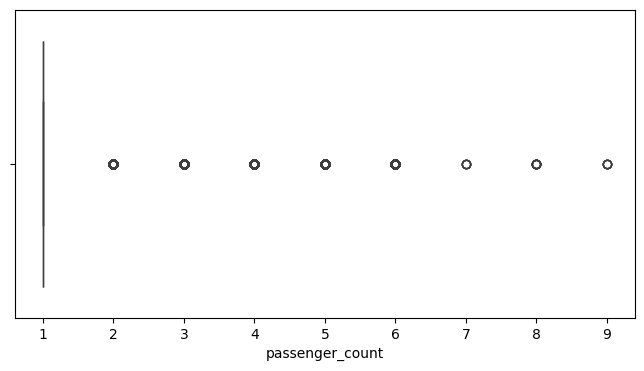

In [125]:
# Box Plot for passenger_count
plt.figure(figsize=(8,4))
sns.boxplot(x=taxi_df['passenger_count'])
plt.show()

---
<p style="font-size: 14px; font-weight: 500; color: blue"> 
"passenger_count" analysis observations:
</p>

- The distribution shows that the column passenger_count has extreme outliers in the data. 
- The data ranges from 1 to 9
- Most of the data value is 1
- Trips with passenger count > 6 does not seem correct

---

In [128]:
taxi_df['trip_distance'].value_counts()

trip_distance
0.00     37732
0.90     25797
1.00     25760
1.10     25458
0.80     25217
         ...  
69.15        1
37.04        1
66.90        1
31.46        1
39.18        1
Name: count, Length: 4117, dtype: int64

In [129]:
taxi_df['trip_distance'].describe()

count   1896400.00
mean          3.86
std         129.41
min           0.00
25%           1.05
50%           1.79
75%           3.40
max      126360.46
Name: trip_distance, dtype: float64

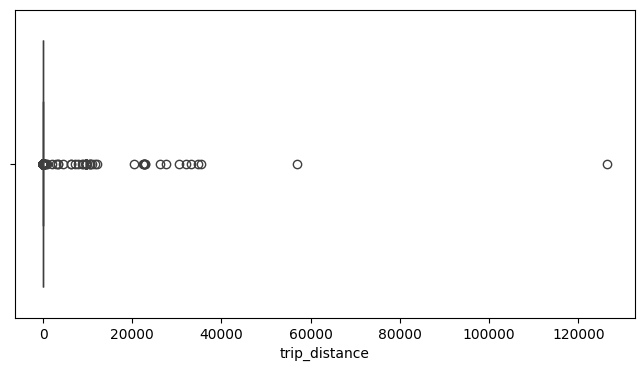

In [130]:
# Box Plot for trip_distance
plt.figure(figsize=(8,4))
sns.boxplot(x=taxi_df['trip_distance'])
plt.show()

---
<p style="font-size: 14px; font-weight: 500; color: blue"> 
"trip_distance" analysis observations:
</p>

- The distribution shows that the column trip_distance has extreme outliers in the data. 
- The trip_distance data ranges from 0 to 126360.46
- Most of the data lies between 1.05 - 3.40
- The median is 1.79 and the mean is 3.86 which is higher than the median
- The standard deviation is 128.15, which shows a high variation in the data
---

In [132]:
taxi_df['payment_type'].value_counts()

payment_type
1    1492374
2     316452
0      64874
4      13685
3       9015
Name: count, dtype: int64

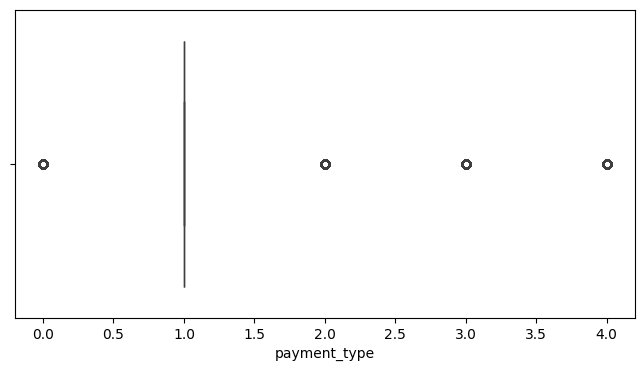

In [133]:
# Box Plot for payment_type
plt.figure(figsize=(8,4))
sns.boxplot(x=taxi_df['payment_type'])
plt.show()

---
<p style="font-size: 14px; font-weight: 500; color: blue"> 
"payment_type" analysis observations:
</p>

- The distribution shows that the column payment_type has outliers in the data.
- There is no payment type = 0 mention in the data dictionary, so this data is not correct
---

In [135]:
taxi_df['fare_amount'].describe()

count   1896400.00
mean         19.92
std         105.54
min           0.00
25%           9.30
50%          13.50
75%          21.90
max      143163.45
Name: fare_amount, dtype: float64

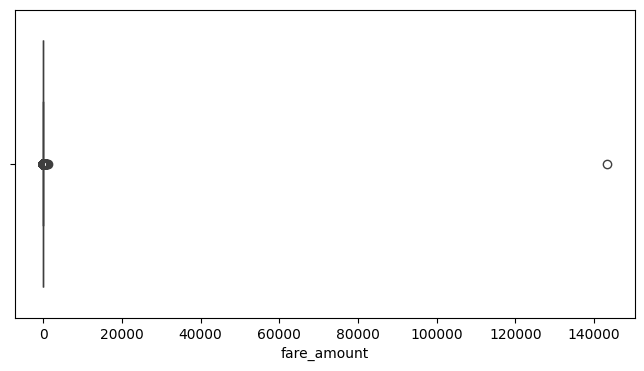

In [136]:
# Box Plot for fare_amount
plt.figure(figsize=(8,4))
sns.boxplot(x = taxi_df['fare_amount'])
plt.show()

---
<p style="font-size: 14px; font-weight: 500; color: blue"> 
"fare_amount" analysis observations:
</p>

- The distribution shows that the column fare_amount has extreme outliers in the data. 
- The fare_amount data ranges from 0 to 143163.45
- The fare = 0 does not look right
---

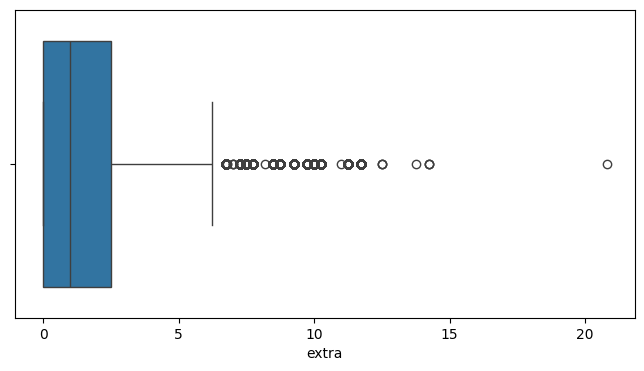

In [141]:
# Box Plot for extra
plt.figure(figsize=(8,4))
sns.boxplot(x = taxi_df['extra'])
plt.show()

In [142]:
taxi_df['extra'].describe()

count   1896400.00
mean          1.59
std           1.83
min           0.00
25%           0.00
50%           1.00
75%           2.50
max          20.80
Name: extra, dtype: float64

---
<p style="font-size: 14px; font-weight: 500; color: blue"> 
"extra" analysis observations:
</p>

- The distribution shows that the column extra has extreme outliers in the data. 
- The extra data ranges from 0 to 20.80, the maximum amount is unusually high
- Most of the data lies between 0 - 2.5
- The median is 1 and the mean is 1.59 which is higher than the median
---

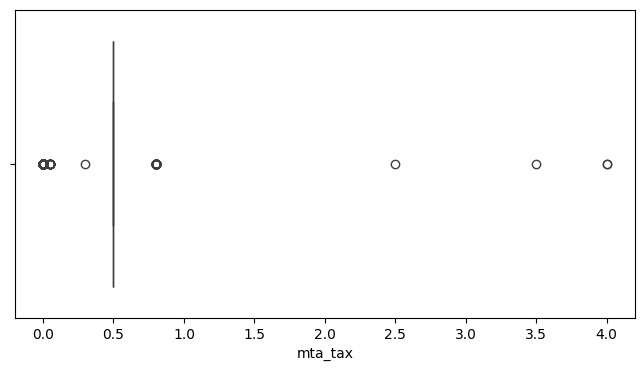

In [151]:
# Box Plot for mta_tax
plt.figure(figsize=(8,4))
sns.boxplot(x = taxi_df['mta_tax'])
plt.show()


In [152]:
taxi_df['mta_tax'].describe()

count   1896400.00
mean          0.50
std           0.05
min           0.00
25%           0.50
50%           0.50
75%           0.50
max           4.00
Name: mta_tax, dtype: float64

---
<p style="font-size: 14px; font-weight: 500; color: blue"> 
"mta_tax" analysis observations:
</p>

- The distribution shows that the column mta_tax has some outliers in the data. 
- The mta_tax data ranges from 0 to 4
- Most of the data lies between 0 - .50
- The median is .50 and the mean is .50, this is expected as it is mentioned in the data dictionary that mta_tax is .50
- The values greater than .50 and 0 seem to be incorrect as per the column description
---

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [159]:
# remove passenger_count > 6
taxi_df = taxi_df[taxi_df["passenger_count"] <= 6]
taxi_df["passenger_count"].value_counts()

passenger_count
1.00    1471779
2.00     277298
3.00      69034
4.00      38537
5.00      23871
6.00      15860
Name: count, dtype: int64

In [161]:
# Continue with outlier handling
taxi_df['trip_distance'].describe()

count   1896379.00
mean          3.86
std         129.41
min           0.00
25%           1.05
50%           1.79
75%           3.40
max      126360.46
Name: trip_distance, dtype: float64

In [163]:
# Checking entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
taxi_df['trip_distance'][taxi_df['trip_distance'] == 0 & (taxi_df['fare_amount']>300)].count()

37722

In [165]:
# Removing data where `trip_distance` is nearly 0 and `fare_amount` is more than 300
taxi_df = taxi_df[taxi_df['trip_distance'] != 0 & (taxi_df['fare_amount']<300)]

In [167]:
# Entries where fare_amount are 0 but the pickup and dropoff zones are different 
# (both distance and fare should not be zero for different zones)

zero_fare_amount = taxi_df[(taxi_df['fare_amount'] == 0) & (taxi_df["PULocationID"] != taxi_df["DOLocationID"])]
zero_fare_amount

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3966            2  2023-01-02 05:12:19   2023-01-02 05:41:45             1.00   
7701            2  2023-01-03 08:27:38   2023-01-03 08:59:16             1.00   
47504           1  2023-01-11 16:47:59   2023-01-11 18:09:08             1.00   
61756           2  2023-01-14 04:18:47   2023-01-14 06:08:25             1.00   
63613           1  2023-01-14 14:47:05   2023-01-14 15:34:07             1.00   
...           ...                  ...                   ...              ...   
1817652         2  2023-09-13 08:41:37   2023-09-13 08:53:16             1.00   
1863299         2  2023-09-25 00:12:38   2023-09-25 01:07:42             1.00   
1871634         1  2023-09-26 18:57:05   2023-09-26 19:07:08             1.00   
1879753         1  2023-09-28 07:00:00   2023-09-28 07:54:54             1.00   
1892743         1  2023-09-30 13:22:42   2023-09-30 13:33:41             1.00   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
3966             17.07        3.00           142             1             2   
7701              8.34        1.00           161           244             2   
47504            53.20        5.00           132           265             3   
61756            68.16        1.00            78           265             2   
63613            20.80        2.00           132           239             4   
...                ...         ...           ...           ...           ...   
1817652           1.04        1.00           234           164             2   
1863299          24.18        4.00           138           265             2   
1871634           2.70       99.00           205           218             1   
1879753           3.00       99.00            95           216             1   
1892743           2.00        5.00           142            48             3   

         fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
3966            0.00   0.00     0.00        0.00          0.00   
7701            0.00   0.00     0.50        0.00          0.00   
47504           0.00   0.00     0.00        0.00         21.30   
61756           0.00   0.00     0.50        0.00          0.00   
63613           0.00   0.00     0.00        0.00          0.00   
...              ...    ...      ...         ...           ...   
1817652         0.00   0.00     0.50        0.00          0.00   
1863299         0.00   0.00     0.50        0.00          0.00   
1871634         0.00   0.00     0.00        0.00          0.00   
1879753         0.00   0.00     0.00        0.00          0.00   
1892743         0.00   0.00     0.00        0.00          0.00   

         improvement_surcharge  total_amount  congestion_surcharge  \
3966                      0.00          0.00                  0.00   
7701                      1.00          4.00                  2.50   
47504                     1.00         22.30                  0.00   
61756                     1.00          1.50                  0.00   
63613                     0.00          0.00                  0.00   
...                        ...           ...                   ...   
1817652                   1.00          4.00                  2.50   
1863299                   1.00          3.25                  0.00   
1871634                   0.00          0.00                  0.00   
1879753                   0.00          0.00                  0.00   
1892743                   1.00          1.00                  0.00   

               date  hour  airport_fee  
3966     2023-01-02     5         0.00  
7701     2023-01-03     8         0.00  
47504    2023-01-11    16         0.00  
61756    2023-01-14     4         0.00  
63613    2023-01-14    14         0.00  
...             ...   ...          ...  
1817652  2023-09-13     8         0.00  
1863299  2023-09-25     0         1.75  
1871634  2023-09-26    18         0.00  
1879753  2023-09-28     7      

In [169]:
# Removing data where fare_amount are 0 but the pickup and dropoff zones are different 

taxi_df = taxi_df.drop(zero_fare_amount.index)

In [171]:
# Entries where trip_distance is more than 250 miles.

taxi_df['trip_distance'][(taxi_df['trip_distance'] > 250)].count()

46

In [173]:
# Removing entries where trip_distance is more than 250 miles.
taxi_df = taxi_df[(taxi_df['trip_distance'] < 250)]

In [175]:
# Handing outliers in the payment_type column

taxi_df["payment_type"].value_counts()

payment_type
1    1479326
2     309867
0      50138
4      12250
3       6824
Name: count, dtype: int64

In [177]:
# Checking mode value of payment_type
taxi_df["payment_type"].mode()

0    1
Name: payment_type, dtype: int64

In [179]:
# Updating rows with 0 value with mode

taxi_df["payment_type"].replace(0, taxi_df["payment_type"].mode()[0] , inplace=True)
taxi_df["payment_type"].value_counts()

payment_type
1    1529464
2     309867
4      12250
3       6824
Name: count, dtype: int64

In [181]:
# Fixing outliers in fare_amount column

taxi_df['fare_amount']

0         32.40
1          7.90
2         11.40
3          6.50
4         25.64
           ... 
1896395    8.60
1896396    5.80
1896397    9.30
1896398   54.80
1896399   17.00
Name: fare_amount, Length: 1858405, dtype: float64

In [183]:
# Fixing outliers in fare_amount column

print(taxi_df['fare_amount'][taxi_df['fare_amount'] == 0].count())

120


In [185]:
# Removing rows with fare_amount = 0

taxi_df = taxi_df[taxi_df["fare_amount"] > 0]
taxi_df['fare_amount'].describe()

count   1858285.00
mean         19.81
std         106.52
min           0.01
25%           9.30
50%          13.50
75%          21.90
max      143163.45
Name: fare_amount, dtype: float64

In [187]:
print(taxi_df['fare_amount'][taxi_df['fare_amount'] > taxi_df['fare_amount'].quantile(.75)].count())

458784


In [189]:
# There are still outliers present in the fare_amount column as a lot of data exist greater than 75th percentile,
# Let,s check values greater than 500
print(taxi_df['fare_amount'][taxi_df['fare_amount'] > 500].count())

16


In [191]:
# Let's remove rows with fare_amount > 500
taxi_df = taxi_df[taxi_df["fare_amount"] <= 500]
taxi_df['fare_amount'].describe()

count   1858269.00
mean         19.72
std          17.76
min           0.01
25%           9.30
50%          13.50
75%          21.90
max         500.00
Name: fare_amount, dtype: float64

In [193]:
# Checking outliers in the extra column
taxi_df['extra'].describe()

count   1858269.00
mean          1.61
std           1.83
min           0.00
25%           0.00
50%           1.00
75%           2.50
max          14.25
Name: extra, dtype: float64

In [195]:
# This shows that the extra column has outliers present, checking values > 5
taxi_df['extra'][taxi_df['extra'] > 5].count()

50160

In [197]:
# Removing the values that are greater than 5
taxi_df = taxi_df[taxi_df["extra"] <= 5]
taxi_df['extra'].describe()

count   1808109.00
mean          1.44
std           1.54
min           0.00
25%           0.00
50%           1.00
75%           2.50
max           5.00
Name: extra, dtype: float64

In [199]:
# Handling outliers in mta_tax
taxi_df['mta_tax'].describe()

count   1808109.00
mean          0.50
std           0.04
min           0.00
25%           0.50
50%           0.50
75%           0.50
max           4.00
Name: mta_tax, dtype: float64

In [201]:
# As per the data dictionary this column value should be .50, so removing values greater than .50

In [203]:
taxi_df['mta_tax'][taxi_df['mta_tax'] > .5].count()

51

In [205]:
# Do any columns need standardising?
taxi_df.dtypes

VendorID                          int64
tpep_pickup_datetime             object
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
date                             object
hour                              int64
airport_fee                     float64
dtype: object

In [207]:
# RatecodeID can be converted to int
# As we have removed the outliers from most of the columns and the rest of the columns data type also seems to be correct 
# So data is pretty standardized at this point

In [209]:
# Converting RatecodeID to int 
taxi_df['RatecodeID'] = taxi_df['RatecodeID'].astype(int)
taxi_df['RatecodeID'].dtype

dtype('int32')

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [212]:
taxi_df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'date',
 'hour',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

---

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Variables Categorization as per taxi_df
</p>

**Categorical Variables**
- VendorID
- RatecodeID
- PULocationID
- DOLocationID
- payment_type
- hour

**Numerical Variables**

- passenger_count
- trip_distance

**Monetary Variables below are Numerical Variables**
- fare_amount
- extra
- mta_tax
- tip_amount
- tolls_amount
- improvement_surcharge
- total_amount
- congestion_surcharge
- airport_fee

**DateTime Variables (categorical Variables)**
- tpep_pickup_datetime
- tpep_dropoff_datetime
- date

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [219]:
taxi_df['hour'].value_counts().sort_values(ascending = False)

hour
18    126984
17    120292
15    113877
19    113491
14    110839
16    109884
13    103495
21    100532
12    100404
20    100382
22     93093
11     92470
10     85109
9      78454
23     72136
8      69471
0      50406
7      50054
1      34617
6      25227
2      22798
3      14832
5       9831
4       9431
Name: count, dtype: int64

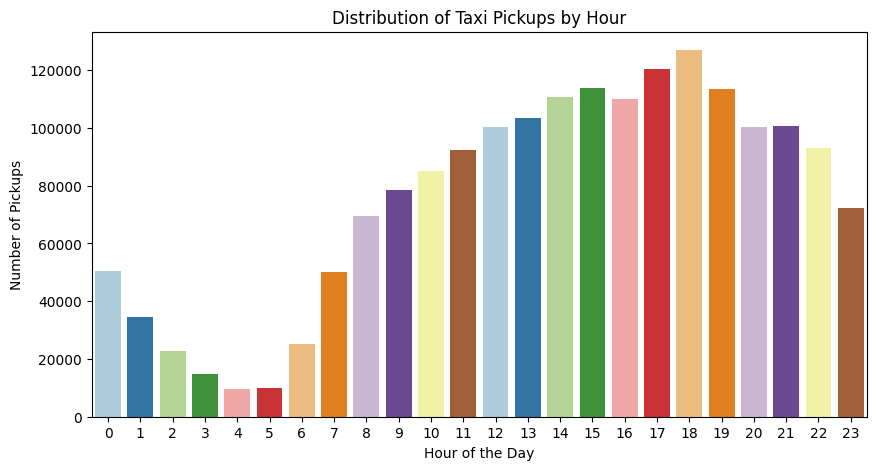

In [221]:
# Find and show the hourly trends in taxi pickups

plt.figure(figsize=(10, 5))
sns.countplot(x="hour", data=taxi_df, palette="Paired")
plt.title("Distribution of Taxi Pickups by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.show()


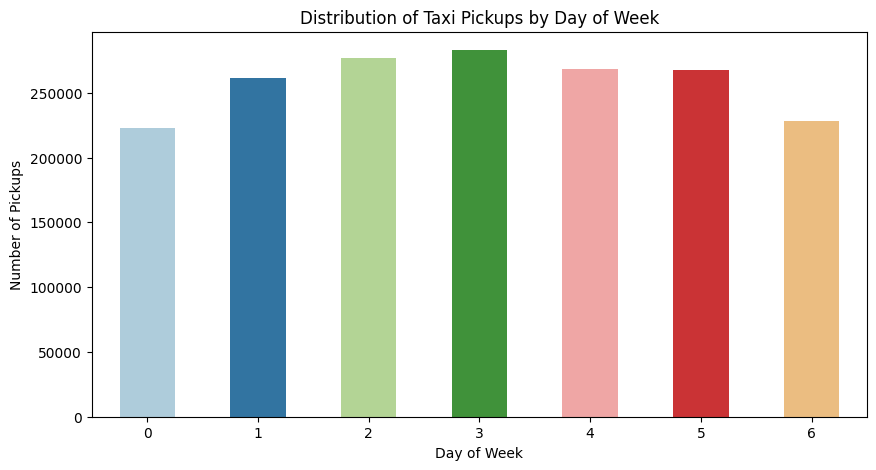

In [222]:
# Find and show the daily trends in taxi pickups (days of the week)

# Converting tpep_pickup_datetime to datetime

taxi_df["tpep_pickup_datetime"] = pd.to_datetime(taxi_df["tpep_pickup_datetime"])

# Extracting day of week from the tpep_pickup_datetime

taxi_df["pickup_day"] = taxi_df["tpep_pickup_datetime"].dt.dayofweek

plt.figure(figsize=(10, 5))
sns.countplot(x="pickup_day", data=taxi_df, palette="Paired", width = .5)
plt.title("Distribution of Taxi Pickups by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Pickups")
plt.show()


In [223]:
taxi_df['pickup_day'].value_counts().sort_values(ascending = False)

pickup_day
3    282975
2    277070
4    268255
5    267442
1    261028
6    228268
0    223071
Name: count, dtype: int64

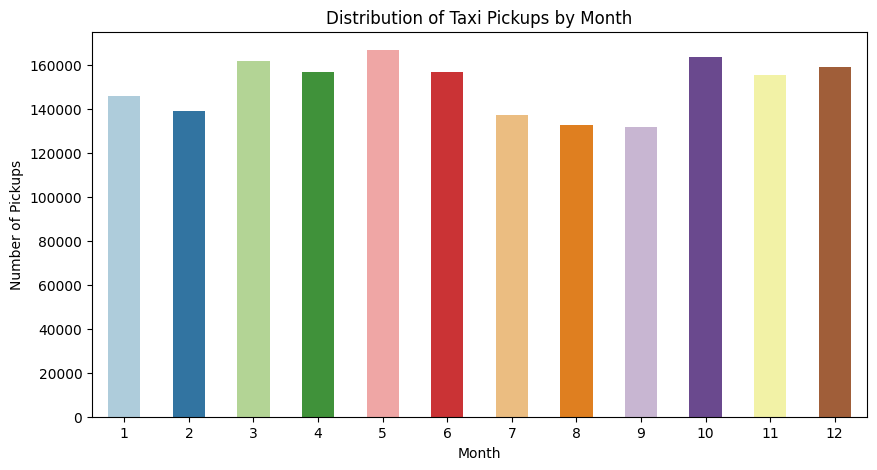

In [224]:
# Show the monthly trends in pickups

# Extracting day of week from the tpep_pickup_datetime

taxi_df["pickup_month"] = taxi_df["tpep_pickup_datetime"].dt.month

plt.figure(figsize=(10, 5))
sns.countplot(x="pickup_month", data=taxi_df, palette="Paired", width = .5)
plt.title("Distribution of Taxi Pickups by Month")
plt.xlabel("Month")
plt.ylabel("Number of Pickups")
plt.show()


In [225]:
taxi_df['pickup_month'].value_counts().sort_values(ascending = False)

pickup_month
5     166934
10    163578
3     161727
12    159239
6     156790
4     156779
11    155781
1     146213
2     139033
7     137248
8     132727
9     132060
Name: count, dtype: int64

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [228]:
# Analyse the above parameters
print(f"fare_amount zero and negative value count is: {taxi_df['fare_amount'][taxi_df['fare_amount'].le(0)].count()}")
print(f"tip_amount zero and negative value count is: {taxi_df['tip_amount'][taxi_df['tip_amount'].le(0)].count()}")
print(f"total_amount zero and negative value count is: {taxi_df['total_amount'][taxi_df['total_amount'].le(0)].count()}")
print(f"trip_distance zero and negative value count is: {taxi_df['trip_distance'][taxi_df['trip_distance'].le(0)].count()}")

fare_amount zero and negative value count is: 0
tip_amount zero and negative value count is: 397597
total_amount zero and negative value count is: 0
trip_distance zero and negative value count is: 0


---

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Yes, these variable did contain 0 values and -ve values, but that has been taken care above in 2.1.1
</p>

- In case of tip_amount it can be zero as may be the passenger did not pay tip
- In case of trip_distance only zeros of those trips are maintained where pickup location and drop location is same and fare amount is also 0

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Yes, we can create another dataframe with non zero values based on above observation about tip_amount and trip_distance
</p>

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

---

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Yes, in case the pickup and drop are same, we should also check if the fare amount is 0 as otherwise it can be invalid records. All the zero and negative values has been taken care in the above 2.1.1 section
</p>

In [240]:
# Create a df with non zero entries for the selected parameters.

filtered_financial_df = taxi_df[
                                (taxi_df["fare_amount"] > 0) & 
                                (taxi_df["tip_amount"] > 0) & 
                                (taxi_df["total_amount"] > 0) & 
                                (taxi_df["trip_distance"] > 0)
                            ]
filtered_financial_df

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1               2  2023-01-01 00:16:41   2023-01-01 00:21:46             2.00   
4               2  2023-01-01 00:43:00   2023-01-01 01:01:00             1.00   
5               1  2023-01-01 00:42:56   2023-01-01 01:16:33             2.00   
6               2  2023-01-01 00:58:00   2023-01-01 01:08:31             2.00   
7               2  2023-01-01 00:16:06   2023-01-01 00:31:59             1.00   
...           ...                  ...                   ...              ...   
1896394         1  2023-09-30 23:00:09   2023-09-30 23:59:38             4.00   
1896395         2  2023-09-30 23:46:34   2023-09-30 23:53:20             1.00   
1896396         1  2023-09-30 23:44:51   2023-09-30 23:49:05             3.00   
1896397         2  2023-09-30 23:11:05   2023-09-30 23:18:42             1.00   
1896399         2  2023-09-30 23:19:47   2023-09-30 23:33:36             1.00   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
1                 1.24           1           161           237             1   
4                19.24           1            66           107             1   
5                 7.10           1           246            37             1   
6                 1.59           1            79           164             1   
7                 3.16           1            79           256             1   
...                ...         ...           ...           ...           ...   
1896394          18.40           2           132           148             1   
1896395           0.79           1           231           231             1   
1896396           0.50           1           158            68             1   
1896397           1.09           1           161           162             1   
1896399           2.97           1           231            68             1   

         fare_amount  ...  tip_amount  tolls_amount  improvement_surcharge  \
1               7.90  ...        2.58          0.00                   1.00   
4              25.64  ...        5.93          0.00                   1.00   
5              34.50  ...        7.90          0.00                   1.00   
6              11.40  ...        3.28          0.00                   1.00   
7              19.10  ...        6.02          0.00                   1.00   
...              ...  ...         ...           ...                    ...   
1896394        70.00  ...       15.00          0.00                   1.00   
1896395         8.60  ...        2.00          0.00                   1.00   
1896396         5.80  ...        2.15          0.00                   1.00   
1896397         9.30  ...        2.86          0.00                   1.00   
1896399        17.00  ...        4.40          0.00                   1.00   

         total_amount  congestion_surcharge        date  hour airport_fee  \
1               15.48                  2.50  2023-01-01     0        0.00   
4               35.57                  2.50  2023-01-01     0        0.00   
5               47.40                  2.50  2023-01-01     0        0.00   
6               19.68                  2.50  2023-01-01     0        0.00   
7               30.12                  2.50  2023-01-01     0        0.00   
...               ...                   ...         ...   ...         ...   
1896394         89.00                  2.50  2023-09-30    23        0.00   
1896395         15.60                  2.50  2023-09-30    23        0.00   
1896396         12.95                  2.50  2023-09-30    23        0.00   
1896397         17.16                  2.50  2023-09-30    23        0.00   
1896399         26.40                  2.50  2023-09-30    23        0.00   

         pickup_day  pickup_month  
1                 6             1  
4                 6             1  
5                 6             1  
6                 6             1  
7                 6             1

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

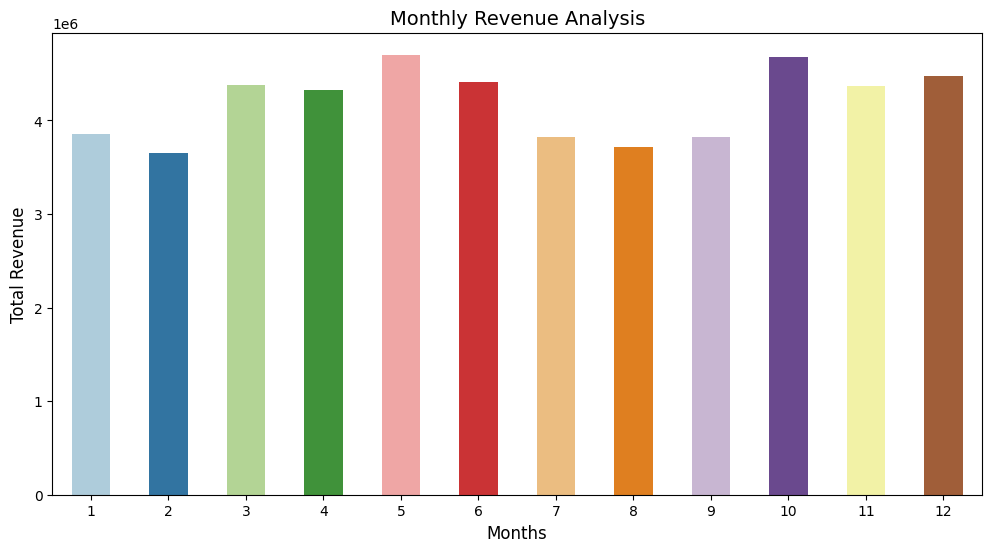

    pickup_month  total_amount
0              1    3856754.57
1              2    3654881.16
2              3    4375546.04
3              4    4324286.92
4              5    4702839.76
5              6    4410079.25
6              7    3825902.70
7              8    3717811.73
8              9    3818742.81
9             10    4682836.80
10            11    4368917.32
11            12    4471665.50


In [243]:
# Group data by month and analyse monthly revenue

monthly_revenue = taxi_df.groupby("pickup_month")["total_amount"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data = monthly_revenue, x = "pickup_month", y = "total_amount", palette = "Paired", width = .5)
plt.title("Monthly Revenue Analysis", fontsize = 14)
plt.xlabel("Months", fontsize = 12)
plt.ylabel("Total Revenue", fontsize = 12)
plt.show()

print(monthly_revenue)

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

   pickup_quarter  total_amount
0               1   11887181.77
1               2   13437205.93
2               3   11362457.24
3               4   13523419.62


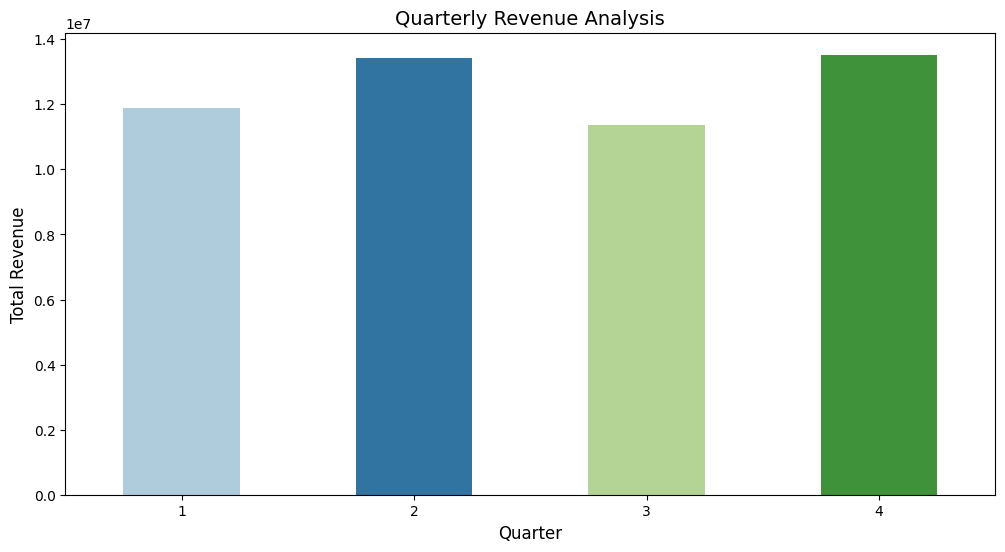

In [246]:
# Calculate proportion of each quarter

# Extracting quarters from pickup datetime
taxi_df["pickup_quarter"] = taxi_df["tpep_pickup_datetime"].dt.quarter

# Group data by quarter and calculating the total revenue
quarterly_revenue = taxi_df.groupby("pickup_quarter")["total_amount"].sum().reset_index()
print(quarterly_revenue)
plt.figure(figsize=(12, 6))
sns.barplot(data = quarterly_revenue, x = "pickup_quarter", y = "total_amount", palette = "Paired", width = .5)
plt.title("Quarterly Revenue Analysis", fontsize = 14)
plt.xlabel("Quarter", fontsize = 12)
plt.ylabel("Total Revenue", fontsize = 12)
plt.show()

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [249]:
# Show how trip fare is affected by distance

correlation_value = filtered_financial_df["trip_distance"].corr(filtered_financial_df["fare_amount"])
print(f"Correlation between Trip Distance and Fare Amount: {correlation_value}")

Correlation between Trip Distance and Fare Amount: 0.946909093287861


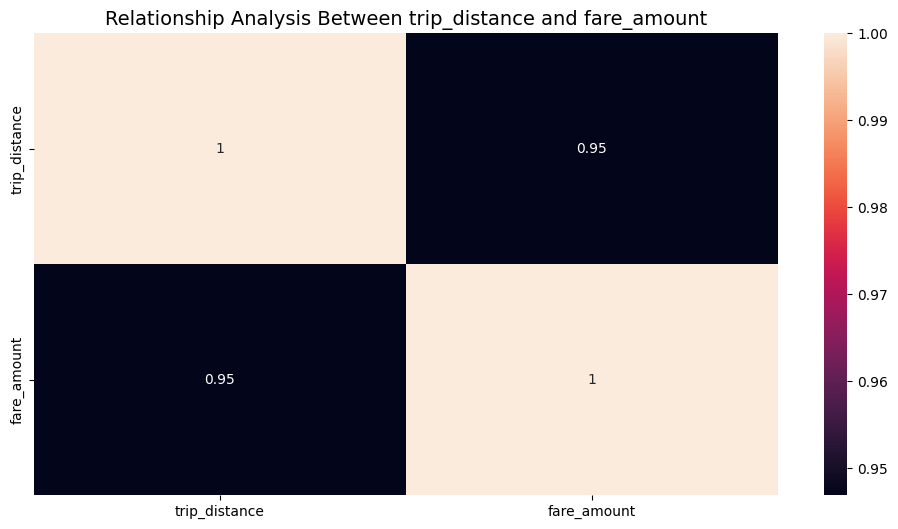

In [251]:
# Plotting heatmap on correlation of trip_distance, fare_amount
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_financial_df[["trip_distance","fare_amount"]].corr(),annot=True)
plt.title("Relationship Analysis Between trip_distance and fare_amount", fontsize = 14)
plt.show()

<p style="font-size: 18px; font-weight: 500; color: blue"> 
The above correlation analysis between trip_distance and fare_amount shows a very strong relationship. This shows that when the trip_distance increases, the fare amount also increases.
</p>

---

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

Correlation between Fare Amount vs Trip Duration is: 0.32465508030806633


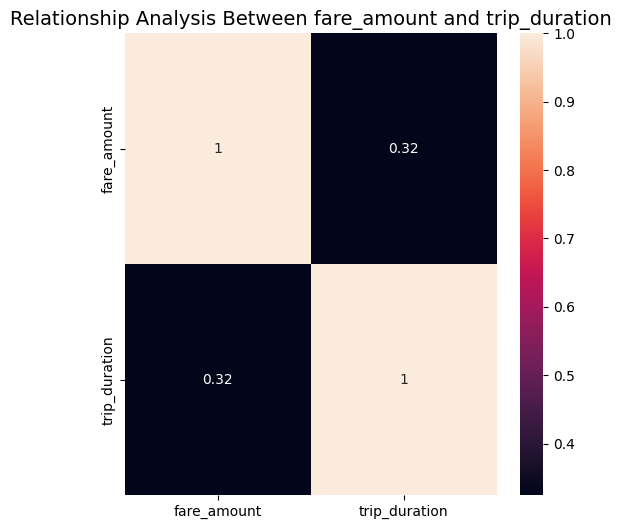

In [255]:
# Show relationship between fare and trip duration

# Calculate trip duration in minutes
filtered_financial_df["trip_duration"] = (filtered_financial_df["tpep_dropoff_datetime"] - filtered_financial_df["tpep_pickup_datetime"]).dt.total_seconds() / 60

# Drop trips with zero or negative durations
filtered_financial_df = filtered_financial_df[filtered_financial_df["trip_duration"] > 0]

corr_fare_duration = filtered_financial_df["fare_amount"].corr(filtered_financial_df["trip_duration"])
print(f"Correlation between Fare Amount vs Trip Duration is: {corr_fare_duration}")

# Plotting heatmap on correlation of trip_distance, fare_amount
plt.figure(figsize=(6, 6))
sns.heatmap(filtered_financial_df[["fare_amount","trip_duration"]].corr(),annot=True)
plt.title("Relationship Analysis Between fare_amount and trip_duration", fontsize = 14)
plt.show()


<p style="font-size: 18px; font-weight: 500; color: blue"> 
The above correlation analysis between trip_duration and fare_amount shows a moderate positive relationship.
</p>

---

Correlation between Fare Amount vs Passenger Count is: 0.03948977572060906


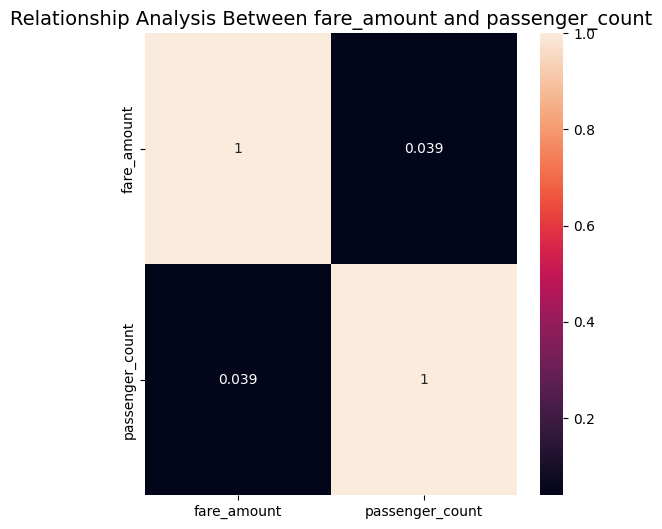

In [258]:
# Show relationship between fare and number of passengers

corr_fare_passenger = filtered_financial_df["fare_amount"].corr(filtered_financial_df["passenger_count"])
print(f"Correlation between Fare Amount vs Passenger Count is: {corr_fare_passenger}")

# Plotting heatmap on correlation of trip_distance, fare_amount
plt.figure(figsize=(6, 6))
sns.heatmap(filtered_financial_df[["fare_amount","passenger_count"]].corr(),annot=True)
plt.title("Relationship Analysis Between fare_amount and passenger_count", fontsize = 14)
plt.show()


<p style="font-size: 18px; font-weight: 500; color: blue"> 
The above correlation analysis between Fare Amount vs Passenger Count shows very weak relationship, almost no corelation.
</p>

---

Correlation between Tip Amount vs Trip DIstance is: 0.7919688252077994


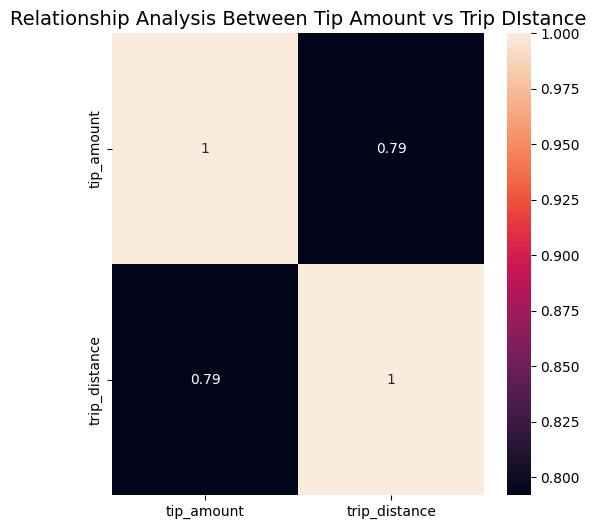

In [261]:
# Show relationship between tip and trip distance

corr_fare_passenger = filtered_financial_df["tip_amount"].corr(filtered_financial_df["trip_distance"])
print(f"Correlation between Tip Amount vs Trip DIstance is: {corr_fare_passenger}")

# Plotting heatmap on correlation of trip_distance, fare_amount
plt.figure(figsize=(6, 6))
sns.heatmap(filtered_financial_df[["tip_amount","trip_distance"]].corr(),annot=True)
plt.title("Relationship Analysis Between Tip Amount vs Trip DIstance", fontsize = 14)
plt.show()


<p style="font-size: 18px; font-weight: 500; color: blue"> 
The above correlation analysis between Tip Amount vs Trip DIstance shows strong positive relationship. Longer distance trips generally gets high tips
</p>

---

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

payment_type
1    1410400
2         23
4         16
3          6
Name: count, dtype: int64


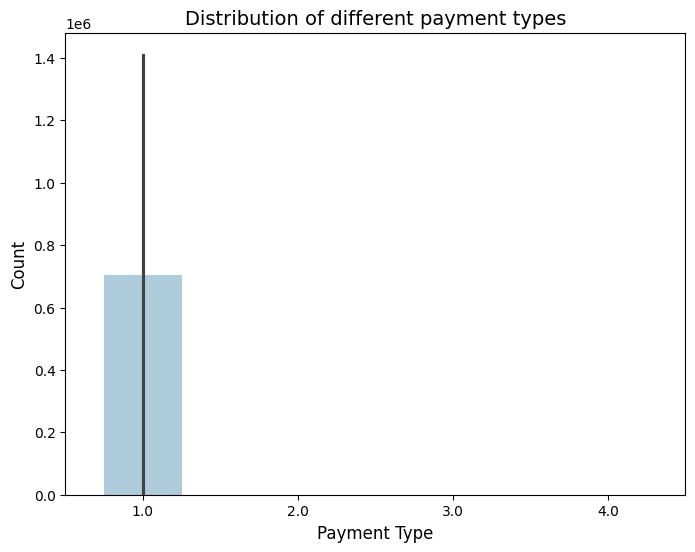

In [265]:
# Analyse the distribution of different payment types (payment_type).
print(filtered_financial_df["payment_type"].sort_values().value_counts())

plt.figure(figsize=(8, 6))
sns.barplot(data = filtered_financial_df, x = "payment_type", y = filtered_financial_df["payment_type"].sort_values().value_counts(), palette = "Paired", width = .5)
plt.title("Distribution of different payment types", fontsize = 14)
plt.xlabel("Payment Type", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute




<p style="font-size: 18px; font-weight: 500; color: blue"> 
The above payment type distribution analysis shows that Credit card is the most preferable mode of payment among passengers.
</p>

---

##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [271]:
# !pip install geopandas

!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [274]:
# import geopandas as gpd
 
import geopandas as gpd

# Read the shapefile using geopandas
zones = gpd.read_file(filepath + "/taxi_zones/taxi_zones.shp") # read the .shp file using gpd
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1        0.12        0.00           Newark Airport           1   
1         2        0.43        0.00              Jamaica Bay           2   
2         3        0.08        0.00  Allerton/Pelham Gardens           3   
3         4        0.04        0.00            Alphabet City           4   
4         5        0.09        0.00            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

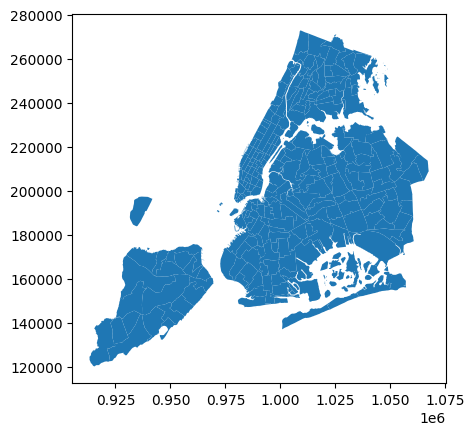

In [277]:
# print(zones.info())
print(zones.info())
# zones.plot()
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [282]:
# Merge zones and trip records using locationID and PULocationID

merged_pickup_data = filtered_financial_df.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")

merged_dropoff_data = filtered_financial_df.merge(zones, left_on="DOLocationID", right_on="LocationID", how="left")

# Checking the columns in merged dataframe
print(merged_pickup_data.columns.tolist())

print(merged_dropoff_data.columns.tolist())

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'date', 'hour', 'airport_fee', 'pickup_day', 'pickup_month', 'trip_duration', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'date', 'hour', 'airport_fee', 'pickup_day', 'pickup_month', 'trip_duration', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [285]:
# Group data by location and calculate the number of trips

# Pickup Grouped Trips

print("****************** Pickup Grouped Trips *******************")

pickup_grouped_trips = merged_pickup_data.groupby(["PULocationID", "zone", "borough"]).size()
pickup_grouped_trips = pickup_grouped_trips.reset_index(name="Number of Pickup Trips")

top_10_pickup_groups = pickup_grouped_trips[[ "PULocationID", "zone","Number of Pickup Trips"]].sort_values(by = "Number of Pickup Trips", ascending = False).head(10)
print(top_10_pickup_groups)
# Dropoff Grouped Trips

print("****************** Dropoff Grouped Trips *******************")

dropoff_grouped_trips = merged_dropoff_data.groupby(["DOLocationID", "zone", "borough"]).size()
dropoff_grouped_trips = dropoff_grouped_trips.reset_index(name="Number of Dropoff Trips")

top_10_dropoff_groups = dropoff_grouped_trips[["DOLocationID", "zone","Number of Dropoff Trips"]].sort_values(by = "Number of Dropoff Trips", ascending = False).head(10)
print(top_10_dropoff_groups)

****************** Pickup Grouped Trips *******************
     PULocationID                          zone  Number of Pickup Trips
206           237         Upper East Side South                   70878
139           161                Midtown Center                   68001
205           236         Upper East Side North                   65034
111           132                   JFK Airport                   61886
140           162                  Midtown East                   52919
121           142           Lincoln Square East                   49860
161           186  Penn Station/Madison Sq West                   49021
199           230     Times Sq/Theatre District                   44369
148           170                   Murray Hill                   43706
208           239         Upper West Side South                   42537
****************** Dropoff Grouped Trips *******************
     DOLocationID                       zone  Number of Dropoff Trips
227           236

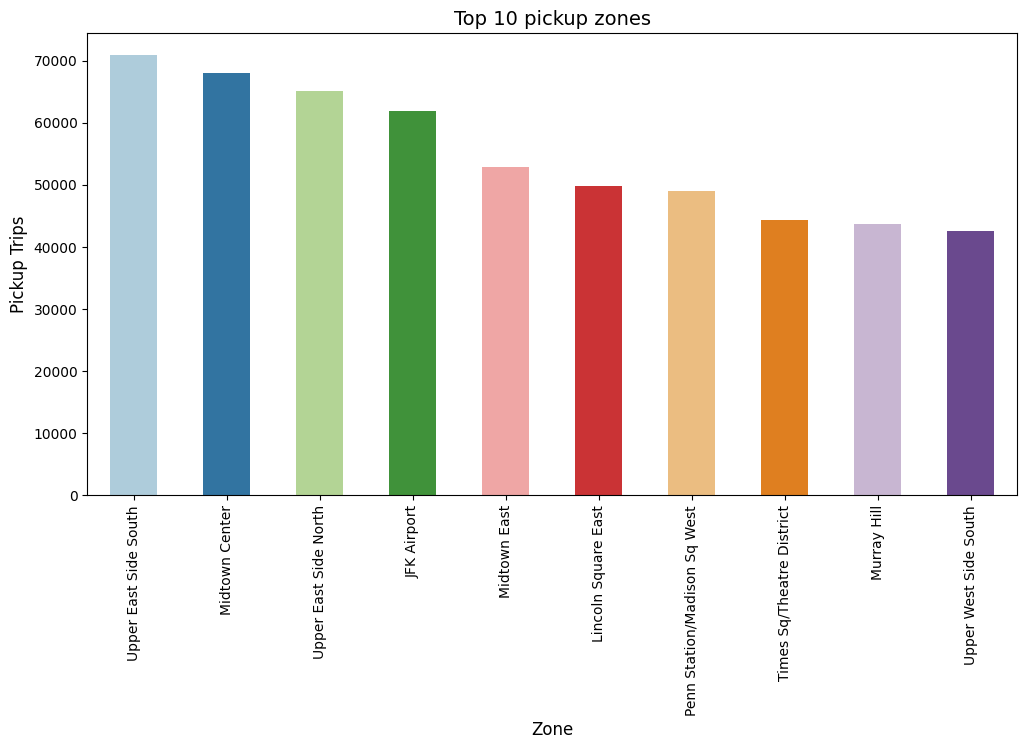

In [287]:
# Plotting bar chart for top 10 pickup groups

plt.figure(figsize=(12, 6))
sns.barplot(data = top_10_pickup_groups, x = "zone", y = "Number of Pickup Trips", palette = "Paired", width = .5)
plt.title("Top 10 pickup zones", fontsize = 14)
plt.xlabel("Zone", fontsize = 12)
plt.ylabel("Pickup Trips", fontsize = 12)
plt.xticks(rotation = 90)
plt.show()

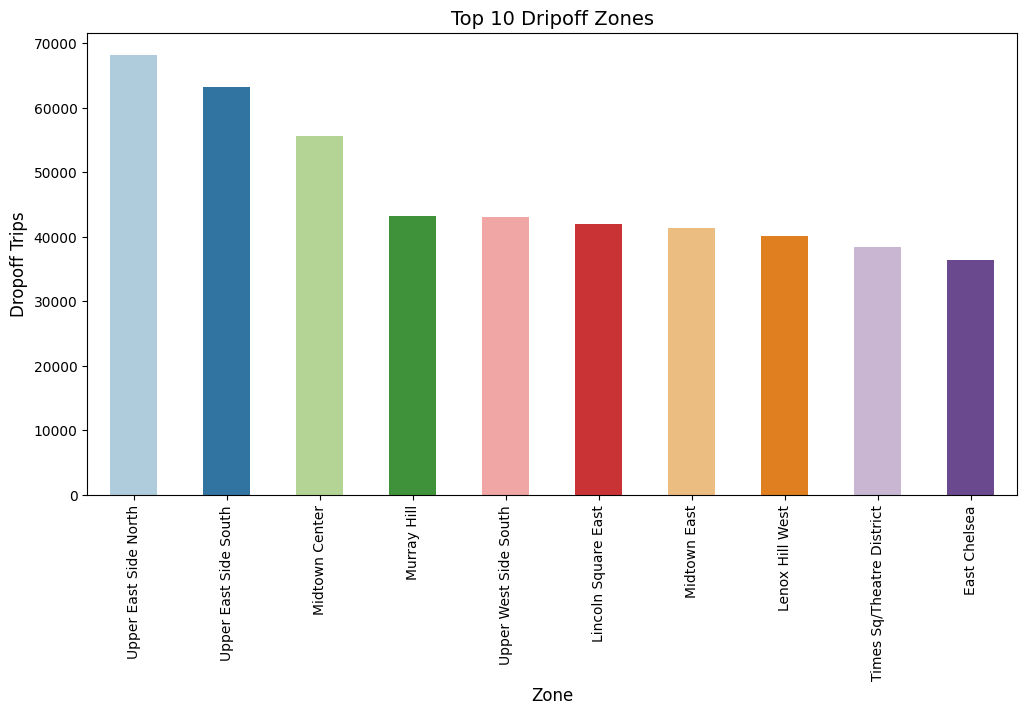

In [289]:
# Plotting bar chart for top 10 dropoff groups

plt.figure(figsize=(12, 6))
sns.barplot(data = top_10_dropoff_groups, x = "zone", y = "Number of Dropoff Trips", palette = "Paired", width = .5)
plt.title("Top 10 Dripoff Zones", fontsize = 14)
plt.xlabel("Zone", fontsize = 12)
plt.ylabel("Dropoff Trips", fontsize = 12)
plt.xticks(rotation = 90)
plt.show()

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [292]:
# Merge trip counts back to the zones GeoDataFrame

# Merging Pickup grouped trips

zones_pickup_merged = zones.merge(pickup_grouped_trips, left_on="LocationID", right_on="PULocationID", how="left")
print(zones_pickup_merged.head())

# Merging Dropoff grouped trips

zones_dropoff_merged = zones.merge(dropoff_grouped_trips, left_on="LocationID", right_on="DOLocationID", how="left")
print(zones_dropoff_merged.head())

   OBJECTID  Shape_Leng  Shape_Area                   zone_x  LocationID  \
0         1        0.12        0.00           Newark Airport           1   
1         2        0.43        0.00              Jamaica Bay           2   
2         3        0.08        0.00  Allerton/Pelham Gardens           3   
3         4        0.04        0.00            Alphabet City           4   
4         5        0.09        0.00            Arden Heights           5   

       borough_x                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   PULocationID          zone_y  borough_y  Number of Pickup Trips  
0          1.00  Newark Airport        EWR     

In [294]:
# Busiest zones as per number of trips:
pickup_grouped_trips.sort_values(by = ["Number of Pickup Trips"], ascending = False).head(50)


PULocationID                           zone    borough  \
206           237          Upper East Side South  Manhattan   
139           161                 Midtown Center  Manhattan   
205           236          Upper East Side North  Manhattan   
111           132                    JFK Airport     Queens   
140           162                   Midtown East  Manhattan   
121           142            Lincoln Square East  Manhattan   
161           186   Penn Station/Madison Sq West  Manhattan   
199           230      Times Sq/Theatre District  Manhattan   
148           170                    Murray Hill  Manhattan   
208           239          Upper West Side South  Manhattan   
141           163                  Midtown North  Manhattan   
203           234                       Union Sq  Manhattan   
59             68                   East Chelsea  Manhattan   
41             48                   Clinton East  Manhattan   
70             79                   East Village  Manhattan   
120           141                Lenox Hill West  Manhattan   
217           249                   West Village  Manhattan   
142           164                  Midtown South  Manhattan   
90            107                       Gramercy  Manhattan   
119           140                Lenox Hill East  Manhattan   
207           238          Upper West Side North  Manhattan   
231           263                 Yorkville West  Manhattan   
198           229  Sutton Place/Turtle Bay North  Manhattan   
214           246      West Chelsea/Hudson Yards  Manhattan   
37             43                   Central Park  Manhattan   
79             90                       Flatiron  Manhattan   
117           138              LaGuardia Airport     Queens   
86            100               Garment District  Manhattan   
94            113        Greenwich Village North  Manhattan   
230           262                 Yorkville East  Manhattan   
95            114        Greenwich Village South  Manhattan   
200           231           TriBeCa/Civic Center  Manhattan   
202           233            UN/Turtle Bay South  Manhattan   
122           143            Lincoln Square West  Manhattan   
116           137                       Kips Bay  Manhattan   
126           148                Lower East Side  Manhattan   
136           158  Meatpacking/West Village West  Manhattan   
123           144            Little Italy/NoLiTa  Manhattan   
129           151               Manhattan Valley  Manhattan   
182           211                           SoHo  Manhattan   
10             13              Battery Park City  Manhattan   
43             50                   Clinton West  Manhattan   
104           125                      Hudson Sq  Manhattan   
76             87       Financial District North  Manhattan   
229           261             World Trade Center  Manhattan   
66             75              East Harlem South  Manhattan   
144           166            Morningside Heights  Manhattan   
61             70                  East Elmhurst     Queens   
77             88       Financial District South  Manhattan   
21             24                   Bloomingdale  Manhattan   

     Number of Pickup Trips  
206                   70878  
139                   68001  
205                   65034  
111                   61886  
140                   52919  
121                   49860  
161                   49021  
199                   44369  
148                   43706  
208                   42537  
141                   42104  
203                   41053  
59                    38057  
41                    37196  
70                    35981  
120                   35642  
217                   34646  
142                   33729  
90                    31609  
119                   29210  
207                   28927  
231                   28624  
198                   28535  
214                   24836  
37                    24236  
79         

<p style="font-size: 18px; font-weight: 500; color: blue"> 
The busiest zone comes out to be "Upper East Side South" in Manhattan with 70,879 trip count
</p>

In [297]:
# Check null valus in merged data
print(zones_pickup_merged["Number of Pickup Trips"].isnull().sum())

# Fill null values with 0 (zones with no recorded trips)
zones_pickup_merged["Number of Pickup Trips"] = zones_pickup_merged["Number of Pickup Trips"].fillna(0)
print(zones_pickup_merged["Number of Pickup Trips"].isnull().sum())

30
0


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

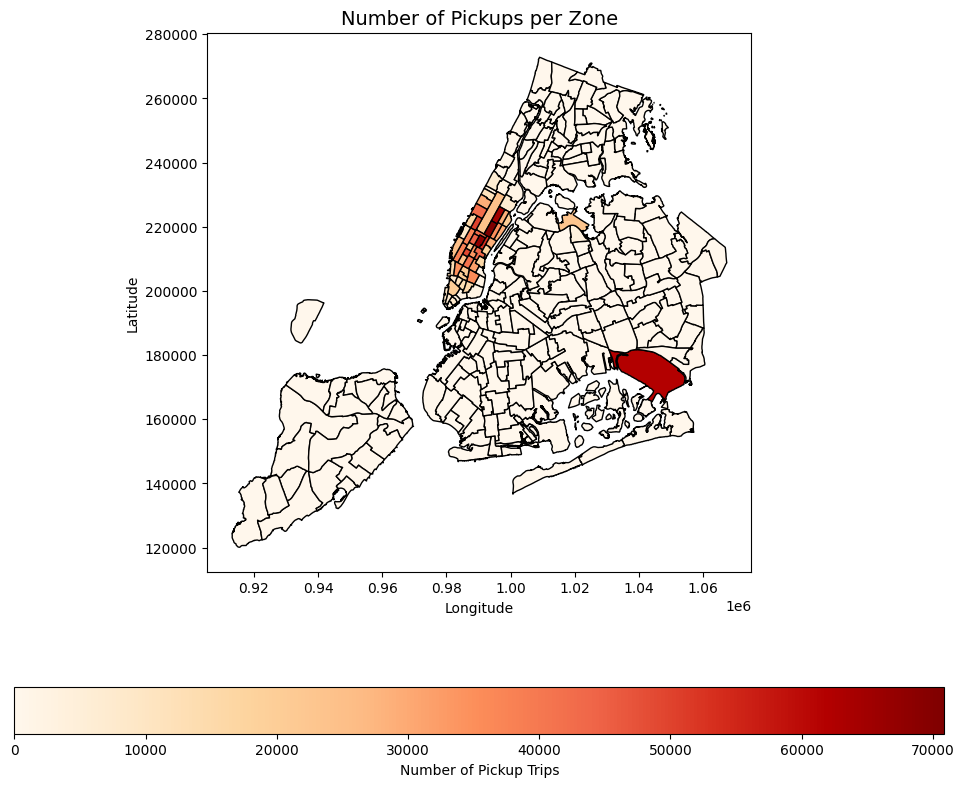

In [302]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

# Plot the map and display it

zones_pickup_merged.plot(column="Number of Pickup Trips",  
                         ax=ax, 
                         cmap="OrRd",  
                         edgecolor="black",  
                         legend=True,  
                         legend_kwds={'label': "Number of Pickup Trips", 'orientation': "horizontal"})

ax.set_title("Number of Pickups per Zone", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


In [304]:
# can you try displaying the zones DF sorted by the number of trips?
sorted_zones = zones_pickup_merged.sort_values(by="Number of Pickup Trips", ascending=False)
sorted_zones[['zone_x','borough_x','Number of Pickup Trips']].head(10)

zone_x  borough_x  Number of Pickup Trips
236         Upper East Side South  Manhattan                70878.00
160                Midtown Center  Manhattan                68001.00
235         Upper East Side North  Manhattan                65034.00
131                   JFK Airport     Queens                61886.00
161                  Midtown East  Manhattan                52919.00
141           Lincoln Square East  Manhattan                49860.00
185  Penn Station/Madison Sq West  Manhattan                49021.00
229     Times Sq/Theatre District  Manhattan                44369.00
169                   Murray Hill  Manhattan                43706.00
238         Upper West Side South  Manhattan                42537.00

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


---
<p style="font-size: 18px; font-weight: 500; color: blue"> 
Below is the detailed analysis:
</p>

**Busiest hours, days and months:**
- The busiest pickup times are 1 PM - 6 PM
- Thursday is the busiest day followed by Wednesday.
- May & October months have more trips then rest of the months

**Trends in revenue collected:**
- Total revenue fluctuates based on the number of trips.
- Peak revenue days align with weekends.

**Trends in Quarterly Revenue:**
- Quarter 4 (Oct - Dec): Highest revenue
- Quarter 2 (Apr - Jun): Second highest revenue
- Quarter 1 (Jan - Mar): Moderate revenue
- Quarter 3 (Jul - Sep): Lowest revenue

**Fare Amount Dependency on Key Factors:**
- Fare amount has strong positive correlation with Trip Distance (0.95) that means longer trips = higher fare.
- Fare amount has moderate correlation with Trip Duration (0.32)
- Fare amount has no correlation with Passenger Count (0.04)

**Tip amount dependency on trip distance:**
- Tip amount has a strong correlation with trip distance (0.79)
- This means longer trips generally receives higher tips.

**Busiest zones:**
- There are 4 busiest zones in Manhattan (Upper East Side South, Midtown Center, Upper East Side North, Midtown East)
- There is 1 busiest zone is Queens (JFK Airport)

---

#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [315]:
zones_pickup_merged.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone_x', 'LocationID',
       'borough_x', 'geometry', 'PULocationID', 'zone_y', 'borough_y',
       'Number of Pickup Trips'],
      dtype='object')

In [317]:
# Find routes which have the slowest speeds at different times of the day

# Calculating the trip duration in hours
filtered_financial_df["trip_duration_hours"] = (pd.to_datetime(filtered_financial_df["tpep_dropoff_datetime"]) - pd.to_datetime(filtered_financial_df["tpep_pickup_datetime"])).dt.total_seconds() / 3600

# Calculating average speed
filtered_financial_df["average_speed_mph"] = filtered_financial_df["trip_distance"] / filtered_financial_df["trip_duration_hours"]

slowest_routes = (
    filtered_financial_df.groupby(["hour", "PULocationID", "DOLocationID"])["average_speed_mph"].mean().reset_index()
)

top_10_slowest_routs = slowest_routes.sort_values(by=["hour", "average_speed_mph"]).head(10)
top_10_slowest_routs


hour  PULocationID  DOLocationID  average_speed_mph
2589     0           158            62               0.76
2069     0           140           264               1.87
3833     0           232           148               4.39
3727     0           231            45               5.04
954      0            87           261               5.05
3492     0           224           224               5.11
1622     0           125            45               5.27
3365     0           209           209               5.71
974      0            88            87               6.28
3440     0           211           211               6.34

How does identifying high-traffic, high-demand routes help us?

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Identifying the high traffic, high demand route can help in below ways:
</p>

- It will help drivers to look for alternate routes which can improve passengers experience with faster rides.
- By knowing the zones which get's most pickup requests can help in adding more taxis in those areas during peak areas.
- It can help in pricing optimization in high demand areas and peak hours.
- Avoiding traffic will help in saving fuel

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [322]:
# Calculating number of trips per hour

hourly_trips = filtered_financial_df['hour'].value_counts().reset_index()

print("*** Hour wise trip count  ***")

hourly_trips.sort_values(by = "hour")

*** Hour wise trip count  ***


hour   count
16     0   39818
18     1   27162
20     2   17613
21     3   10989
23     4    6333
22     5    6581
19     6   18497
17     7   39356
15     8   55767
13     9   61208
12    10   64192
11    11   69581
10    12   75652
8     13   77537
5     14   83658
3     15   86424
4     16   84413
1     17   95374
0     18  102212
2     19   91467
7     20   81188
6     21   82044
9     22   75917
14    23   57462

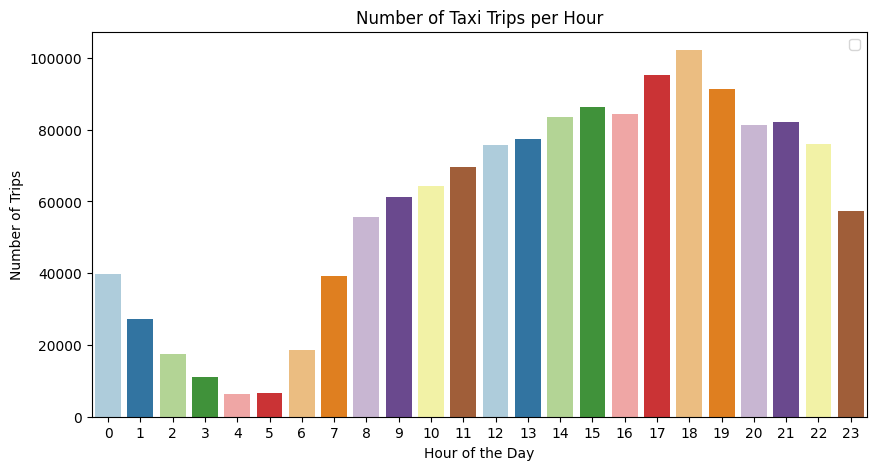

In [324]:
# Visualise the number of trips per hour and find the busiest hour

plt.figure(figsize=(10, 5))
sns.barplot(data=hourly_trips, x="hour", y="count", palette="Paired")
plt.title("Number of Taxi Trips per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.legend()
plt.show()

<p style="font-size: 18px; font-weight: 500; color: blue"> 
The busiest hour of the day is the 18th hour with a total of 1,02,213 trips
</p>


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [329]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.05

# Storing 5 busiest hours in dataframe
busiest_hours = filtered_financial_df['hour'].value_counts().head(5).reset_index()

# Scaling up the number of trips to estimate the actual count
busiest_hours["estimated_actual_trips"] = busiest_hours["count"] / sample_fraction
busiest_hours


hour   count  estimated_actual_trips
0    18  102212              2044240.00
1    17   95374              1907480.00
2    19   91467              1829340.00
3    15   86424              1728480.00
4    16   84413              1688260.00

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

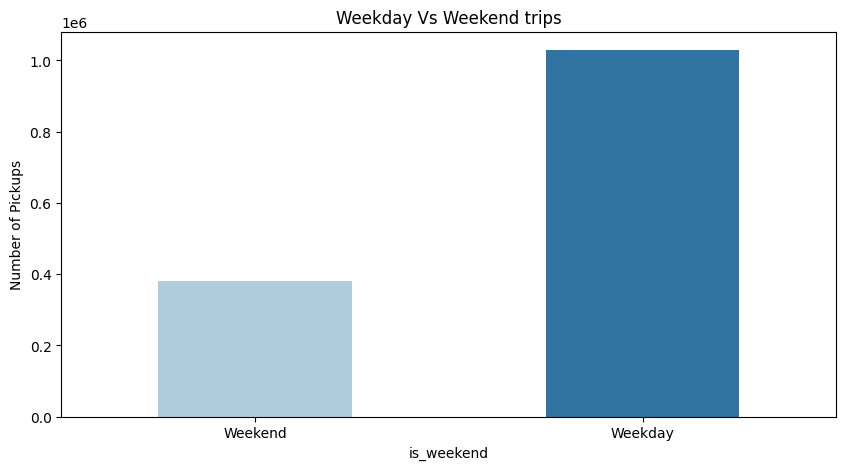

In [332]:
# Compare traffic trends for the week days and weekends

filtered_financial_df["tpep_pickup_datetime"] = pd.to_datetime(filtered_financial_df["tpep_pickup_datetime"])

# Extracting day of week from the tpep_pickup_datetime

filtered_financial_df["pickup_day"] = filtered_financial_df["tpep_pickup_datetime"].dt.dayofweek

# Categorize as weekday or weekend
filtered_financial_df["is_weekend"] = filtered_financial_df["pickup_day"].apply(lambda x: "Weekend" if x in [5, 6] else "Weekday")

plt.figure(figsize=(10, 5))
sns.countplot(x="is_weekend", data=filtered_financial_df, palette="Paired", width = .5)
plt.title("Weekday Vs Weekend trips")
plt.ylabel("Number of Pickups")
plt.show()



In [333]:
# Grouping the data by hour and is_weekend category

weekday_hourly_trips = filtered_financial_df[filtered_financial_df["is_weekend"] == "Weekday"].groupby("hour").size()
weekend_hourly_trips = filtered_financial_df[filtered_financial_df["is_weekend"] == "Weekend"].groupby("hour").size()


In [334]:
# Converting to DataFrame for weekend and weekday data
hourly_comparison_df = pd.DataFrame({
    "Weekday Trips": weekday_hourly_trips, 
    "Weekend Trips": weekend_hourly_trips
})

# Print the hour wise data
hourly_comparison_df

Weekday Trips  Weekend Trips
hour                              
0             18776          21042
1              9477          17685
2              5000          12613
3              2865           8124
4              2430           3903
5              5067           1514
6             15794           2703
7             34951           4405
8             48570           7197
9             49539          11669
10            48424          15768
11            50722          18859
12            54193          21459
13            55340          22197
14            61091          22567
15            63586          22838
16            61002          23411
17            71270          24104
18            78163          24049
19            68883          22584
20            62182          19006
21            63298          18746
22            57379          18538
23            41098          16364

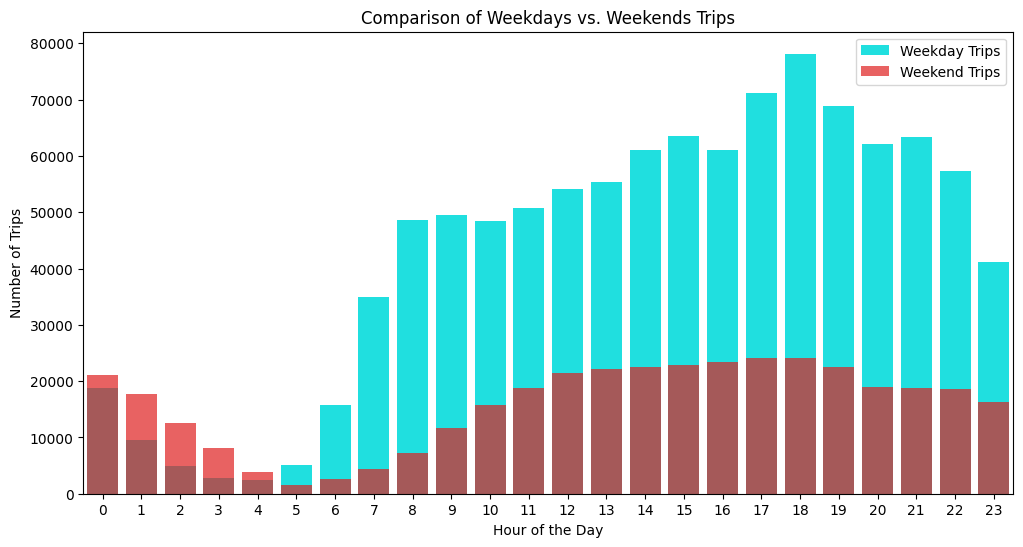

In [335]:
# Grouped bar chart for Weekday Vs Weekend Trips
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_comparison_df, x="hour", y="Weekday Trips", color="cyan", label="Weekday Trips")
sns.barplot(data=hourly_comparison_df, x="hour", y="Weekend Trips", color="red", label="Weekend Trips", alpha=0.7)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Comparison of Weekdays vs. Weekends Trips")
plt.legend()
plt.show()

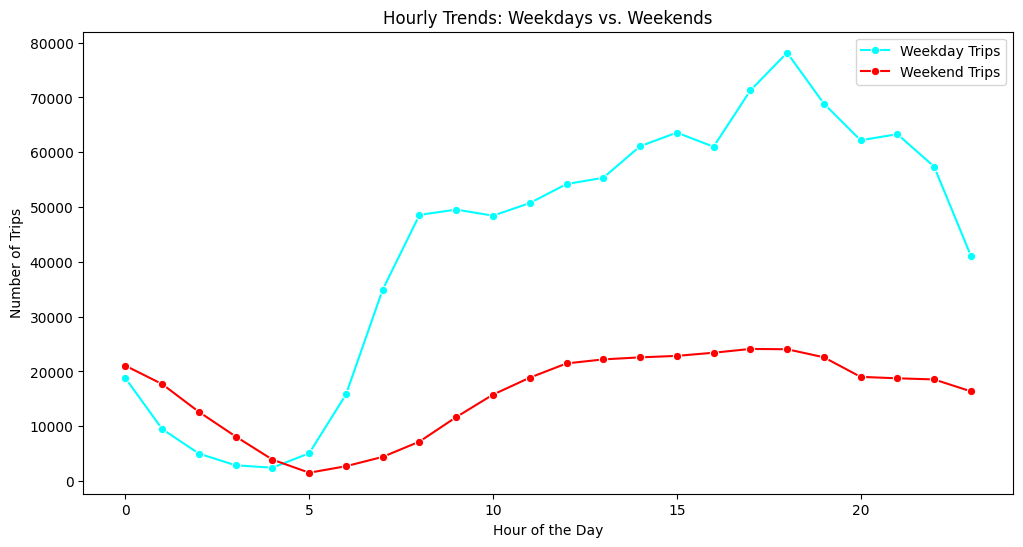

In [336]:
# Line chart for Weekday Vs Weekend Trips
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_comparison_df, x="hour", y="Weekday Trips", marker="o", label="Weekday Trips", color="cyan")
sns.lineplot(data=hourly_comparison_df, x="hour", y="Weekend Trips", marker="o", label="Weekend Trips", color="red")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Hourly Trends: Weekdays vs. Weekends")
plt.legend()
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

---
<p style="font-size: 18px; font-weight: 500; color: blue"> 
Below is the detailed analysis:
</p>

**Trip Patterns for weekdays and weekends**
- Weekdays Have Higher Demand in Morning & Evening Rush Hours
- Weekday trips increase sharply from 6 AM and keep increasing till 7 PM due to the demand for working commuters.
- Weekend shows high demand late at night probably due to people going out to enjoy dinners or nightlife
- Weekends have very little demand from 5 AM to 8 AM as people may wake up late due to the weekend.
- Weekend shows an increase in demand after noon, most probably due to outings, tourism

**How will finding busy and quiet hours for each day help us?**
- Understanding busy and quiet hours will help in improving the taxi services, increase revenue, and optimize driver efficiency.
- More taxis can be deployed during the peak hours.
- This will reduce wait time for passengers, improving their experience.
- During early morning as demand is low, less fleet can be deployed to save fuel.
- Prices can be optimized e.g. prices can be increased during the high demand hours, which will help drivers to earn more.

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [341]:
# Find top 10 pickup and dropoff zones

print(" ****************** Top 10 Pickup Zones ****************** ")

top_10_pickup_zone = pickup_grouped_trips[['zone', 'Number of Pickup Trips']].sort_values(by = ["Number of Pickup Trips"], ascending = False).head(10)
print(top_10_pickup_zone)

print("\n")

print(" ****************** Top 10 Dropoff Zones ****************** ")

top_10_dropoff_zones = dropoff_grouped_trips[['zone', 'Number of Dropoff Trips']].sort_values(by = ["Number of Dropoff Trips"], ascending = False).head(10)
print(top_10_dropoff_zones)

 ****************** Top 10 Pickup Zones ****************** 
                             zone  Number of Pickup Trips
206         Upper East Side South                   70878
139                Midtown Center                   68001
205         Upper East Side North                   65034
111                   JFK Airport                   61886
140                  Midtown East                   52919
121           Lincoln Square East                   49860
161  Penn Station/Madison Sq West                   49021
199     Times Sq/Theatre District                   44369
148                   Murray Hill                   43706
208         Upper West Side South                   42537


 ****************** Top 10 Dropoff Zones ****************** 
                          zone  Number of Dropoff Trips
227      Upper East Side North                    68214
228      Upper East Side South                    63246
153             Midtown Center                    55636
162            

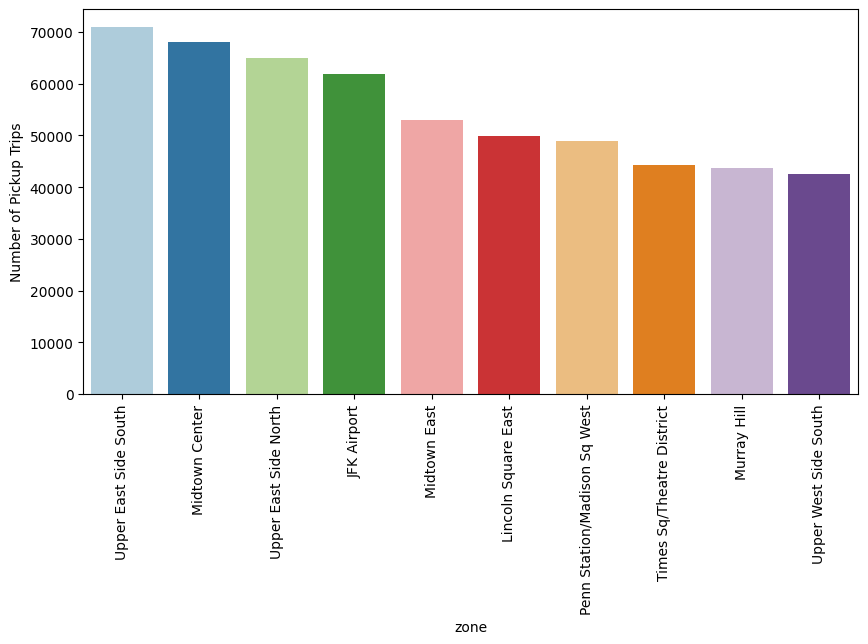

In [346]:
# Plotting top 10 pickup zones

plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_pickup_zone, x="zone", y="Number of Pickup Trips", palette="Paired")
plt.xticks(rotation = 90)
plt.show()

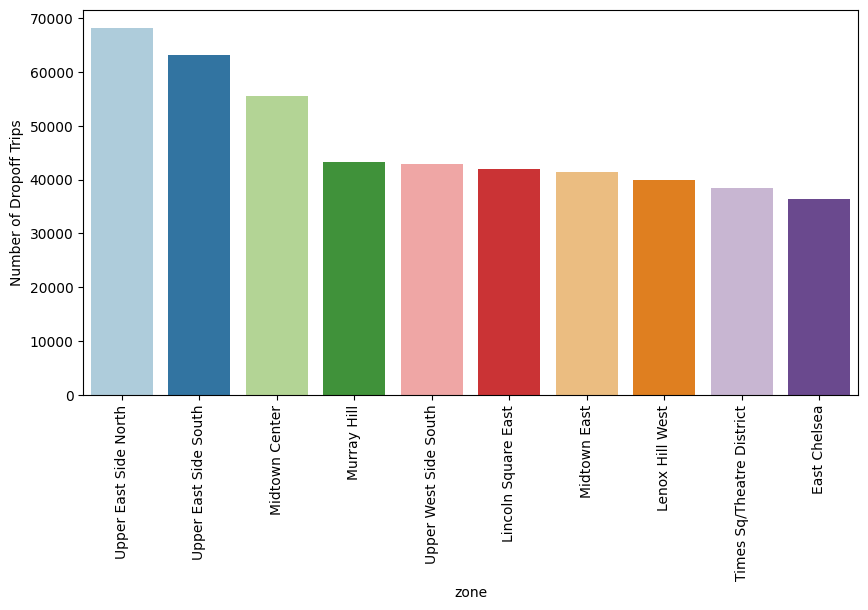

In [349]:
# Plotting top 10 dropoff zones

plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_dropoff_zones, x="zone", y="Number of Dropoff Trips", palette="Paired")
plt.xticks(rotation = 90)
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [352]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Merge pickup and dropoff counts into a single DataFrame
pickup_dropoff_ratio = pickup_grouped_trips.merge(dropoff_grouped_trips, on="zone", how="outer")

# Calculate the pickup/dropoff ratio
pickup_dropoff_ratio["pickup_dropoff_ratio"] = (pickup_dropoff_ratio["Number of Pickup Trips"] / pickup_dropoff_ratio["Number of Dropoff Trips"])

print(" ****************** Top 10 Zones (Highest Pickup/Dropoff Ratio) ****************** ")
top_10_highest_ratio = pickup_dropoff_ratio.sort_values(by="pickup_dropoff_ratio", ascending=False).head(10)
print(top_10_highest_ratio[["zone", "pickup_dropoff_ratio"]])

print("\n")

print(" ****************** Bottom 10 Zones (Lowest Pickup/Dropoff Ratio) ****************** ")
top_10_lowest_ratio = pickup_dropoff_ratio.sort_values(by="pickup_dropoff_ratio", ascending=True).head(10)
print(top_10_lowest_ratio[["zone", "pickup_dropoff_ratio"]])

 ****************** Top 10 Zones (Highest Pickup/Dropoff Ratio) ****************** 
                                 zone  pickup_dropoff_ratio
66                      East Elmhurst                 11.17
120                       JFK Airport                  4.35
200  Saint Michaels Cemetery/Woodside                  2.40
130                 LaGuardia Airport                  1.76
179      Penn Station/Madison Sq West                  1.65
105           Greenwich Village South                  1.40
40                       Central Park                  1.39
242                      West Village                  1.35
154                      Midtown East                  1.28
95                   Garment District                  1.25


 ****************** Bottom 10 Zones (Lowest Pickup/Dropoff Ratio) ****************** 
                         zone  pickup_dropoff_ratio
165            Newark Airport                  0.01
141                   Madison                  0.01
35          

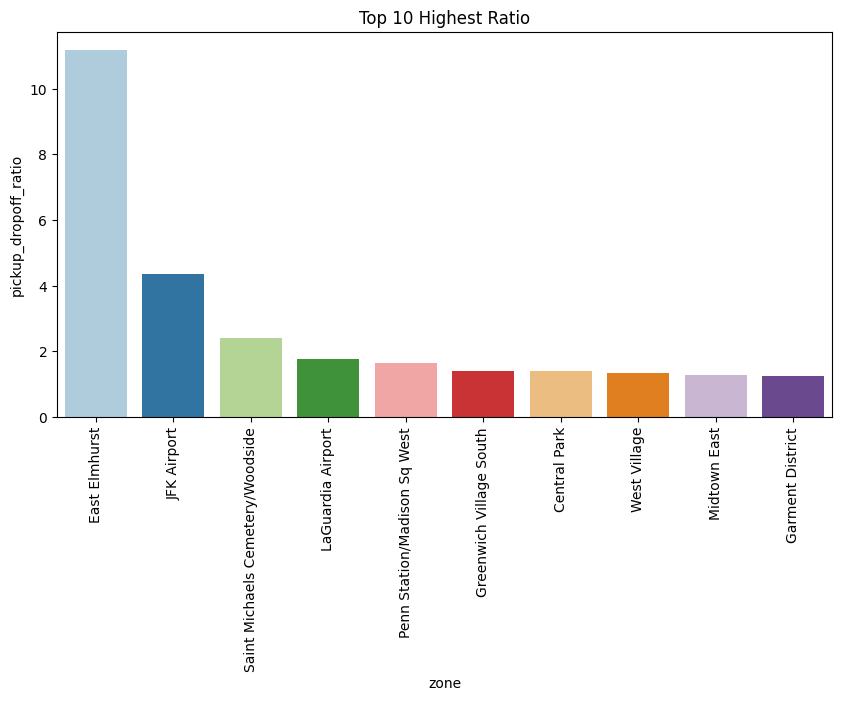

In [354]:
# Plotting top 10 pickup_dropoff zones

plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_highest_ratio, x="zone", y="pickup_dropoff_ratio", palette="Paired")
plt.title("Top 10 Highest Ratio")
plt.xticks(rotation = 90)
plt.show()

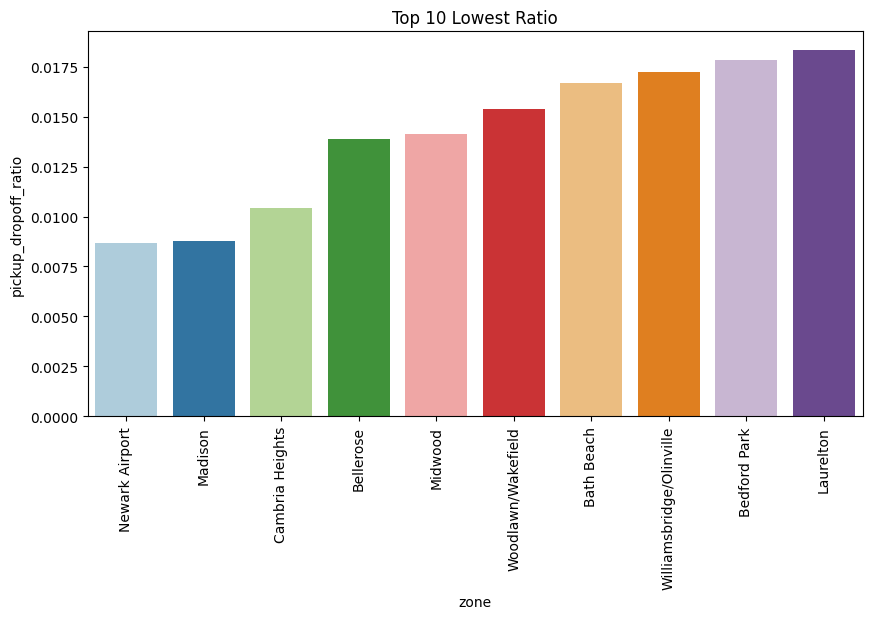

In [356]:
# Plotting Lowest 10 pickup_dropoff zones

plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_lowest_ratio, x="zone", y="pickup_dropoff_ratio", palette="Paired")
plt.title("Top 10 Lowest Ratio")
plt.xticks(rotation = 90)
plt.show()

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [359]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Filtering the night hours from pickup data nd dropoff data

night_pickup_filtered_data = merged_pickup_data[merged_pickup_data["hour"].isin([23, 0, 1, 2, 3, 4, 5])]
night_dropoff_filtered_data = merged_dropoff_data[merged_dropoff_data["hour"].isin([23, 0, 1, 2, 3, 4, 5])]

# Grouping filtered data
grouped_night_pickup_trips = night_pickup_filtered_data.groupby("PULocationID").size().reset_index(name="Night Pickups")
grouped_night_dropoff_trips = night_dropoff_filtered_data.groupby("DOLocationID").size().reset_index(name="Night Dropoffs")

print(" ******* Top 10 busiest PickUp zones during night hours ******* ")
print("\n")

# Merging pickup trips with zone names
night_pickup_trips = grouped_night_pickup_trips.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")

# Fetching top 10-night pickups
top_night_pickups = night_pickup_trips.sort_values(by="Night Pickups", ascending=False).head(10)

print(top_night_pickups[['zone', 'borough', 'Night Pickups']])

print("\n")

print(" ******* Top 10 busiest DropOff zones during night hours ******* ")
print("\n")

# Merging dropoff trips with zone names
night_dropoff_trips = grouped_night_dropoff_trips.merge(zones, left_on="DOLocationID", right_on="LocationID", how="left")

# Fetching top 10-night dropoffs
top_night_dropoffs = night_dropoff_trips.sort_values(by="Night Dropoffs", ascending=False).head(10)

print(top_night_dropoffs[['zone', 'borough', 'Night Dropoffs']])

 ******* Top 10 busiest PickUp zones during night hours ******* 


                             zone    borough  Night Pickups
52                   East Village  Manhattan          13218
178                  West Village  Manhattan          10764
85                    JFK Airport     Queens           9483
99                Lower East Side  Manhattan           8261
29                   Clinton East  Manhattan           8197
72        Greenwich Village South  Manhattan           7467
163     Times Sq/Theatre District  Manhattan           5836
127  Penn Station/Madison Sq West  Manhattan           5413
113                 Midtown South  Manhattan           4880
42                   East Chelsea  Manhattan           4813


 ******* Top 10 busiest DropOff zones during night hours ******* 


                      zone    borough  Night Dropoffs
78            East Village  Manhattan            6814
46            Clinton East  Manhattan            5147
164            Murray Hill  Manhattan    

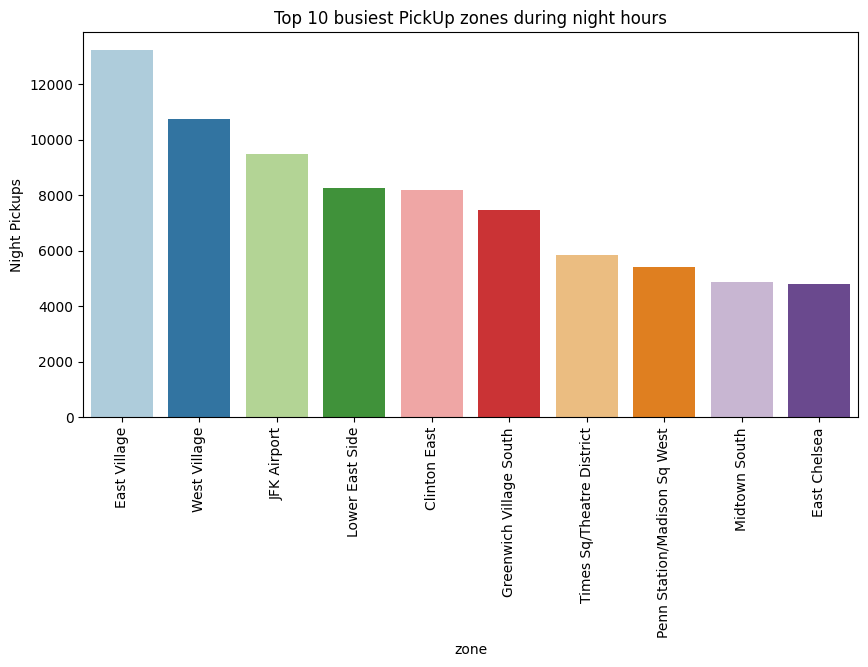

In [361]:
# Plotting Top 10 busiest PickUp zones during night hours

plt.figure(figsize=(10, 5))
sns.barplot(data=top_night_pickups, x="zone", y="Night Pickups", palette="Paired")
plt.title("Top 10 busiest PickUp zones during night hours")
plt.xticks(rotation = 90)
plt.show()

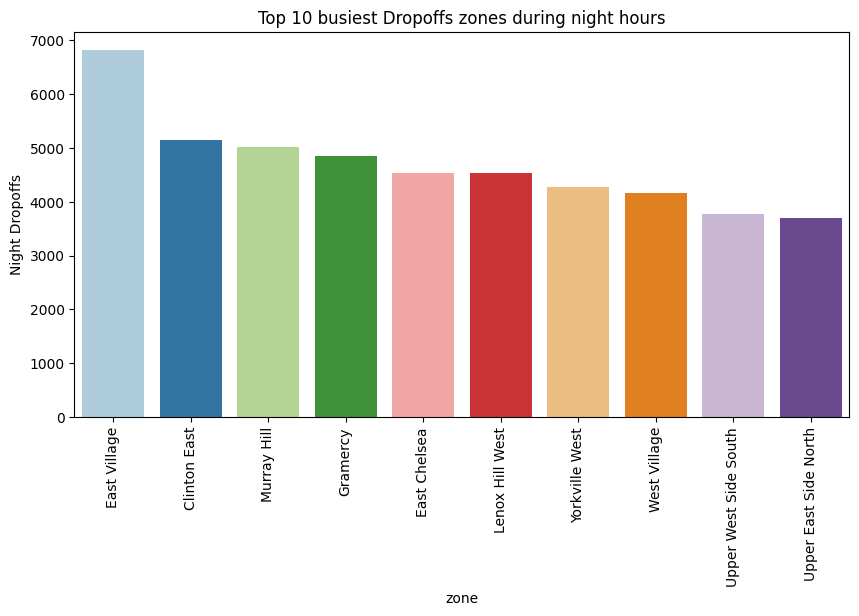

In [362]:
# Plotting Top 10 busiest DropOff zones during night hours

plt.figure(figsize=(10, 5))
sns.barplot(data = top_night_dropoffs, x="zone", y="Night Dropoffs", palette="Paired")
plt.title("Top 10 busiest Dropoffs zones during night hours")
plt.xticks(rotation = 90)
plt.show()

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [366]:
# Filter for night hours (11 PM to 5 AM)

# Night revenue:

night_revenue = round(night_pickup_filtered_data["total_amount"].sum())
print(f"Night Revenue: USD {night_revenue}")

# Day revenue:

filtered_day_data = merged_pickup_data[merged_pickup_data["hour"].isin([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])]
day_revenue = round(filtered_day_data["total_amount"].sum())
print(f"Day Revenue: USD {day_revenue}")

# Total revenue:

total_revenue = night_revenue + day_revenue
print(f"Total Revenue: USD {total_revenue}")

# Night Revenue Share

night_revenue_share = round((night_revenue / total_revenue) * 100)
print(f"Night Revenue Share: {night_revenue_share}%")

# Day Revenue Share

day_revenue_share = round((day_revenue / total_revenue) * 100)
print(f"Day Revenue Share: {day_revenue_share}%")

Night Revenue: USD 4783558
Day Revenue: USD 35388629
Total Revenue: USD 40172187
Night Revenue Share: 12%
Day Revenue Share: 88%


<div style="border: 1px solid black; width: 50%; margin: auto; text-align: center;">
<p style="text-align: center; font-size: 18px; font-weight: 500; color: blue"> 
Revenue share for night time and day time hours.
</p>

|       | |
|:----------------|:-----------|
| **Night Revenue:** | USD 5037415 |
| **Day Revenue:** | USD 37252635  |
| **Total Revenue:** | USD 42290050  |
| **Night Revenue Share:** | 12% |
| **Day Revenue Share:** | 88%|

</div>

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

   passenger_count  fare_per_mile_per_passenger
0             1.00                         9.38
1             2.00                         5.08
2             3.00                         3.38
3             4.00                         4.01
4             5.00                         1.60
5             6.00                         1.29


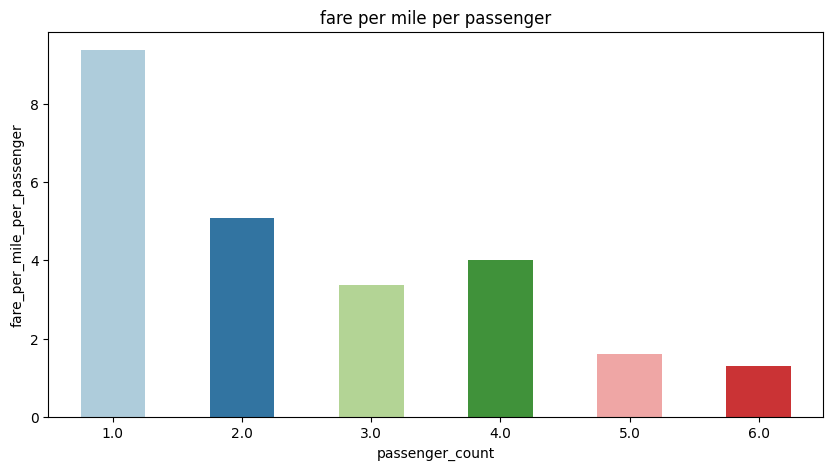

In [371]:
# Analyse the fare per mile per passenger for different passenger counts

# Calculating the fare amount per mile for each trip

merged_pickup_data["fare_per_mile"] = merged_pickup_data["fare_amount"] / merged_pickup_data["trip_distance"]

# Calculating fare amount per mile per passenger
merged_pickup_data["fare_per_mile_per_passenger"] = merged_pickup_data["fare_per_mile"] / merged_pickup_data["passenger_count"]

# Grouping by passenger count and calculating average fare per mile per passenger

grouped_per_mile_per_passenger = merged_pickup_data.groupby("passenger_count")["fare_per_mile_per_passenger"].mean()

fare_per_mile_per_passenger = grouped_per_mile_per_passenger.reset_index().sort_values(by="passenger_count")

print(fare_per_mile_per_passenger)

plt.figure(figsize=(10, 5))
sns.barplot(x="passenger_count", y = "fare_per_mile_per_passenger", data=fare_per_mile_per_passenger, palette="Paired", width = .5)
plt.title("fare per mile per passenger")
plt.show()

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [374]:
# Compare the average fare per mile for different days and for different times of the day

#  fare per mile for different days
avg_fare_per_mile_day = merged_pickup_data.groupby("pickup_day")["fare_per_mile"].mean().reset_index()

print("*****  Average fare for different days *****")
print("\n")
print(avg_fare_per_mile_day)

# Fare for different times of the day
avg_fare_per_mile_hour = merged_pickup_data.groupby("hour")["fare_per_mile"].mean().reset_index()

print("*****  Average fare for different times of the day *****")
print("\n")
print(avg_fare_per_mile_hour)

*****  Average fare for different days *****


   pickup_day  fare_per_mile
0           0           9.30
1           1           9.58
2           2           9.44
3           3           9.82
4           4           9.47
5           5           9.22
6           6          10.47
*****  Average fare for different times of the day *****


    hour  fare_per_mile
0      0           7.84
1      1           8.75
2      2           8.14
3      3           7.61
4      4          11.21
5      5          12.41
6      6           9.70
7      7           9.07
8      8           9.04
9      9           9.25
10    10           9.38
11    11           9.81
12    12          10.02
13    13          10.14
14    14          10.22
15    15          10.27
16    16          12.56
17    17          10.71
18    18           9.89
19    19           9.47
20    20           8.14
21    21           8.14
22    22           8.47
23    23           8.79


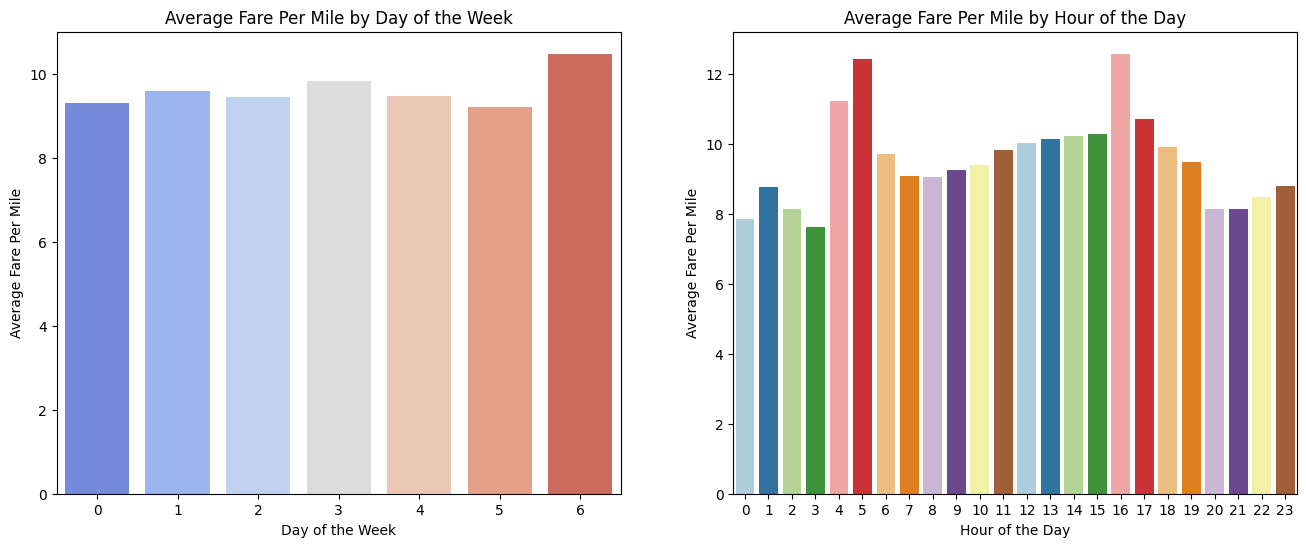

In [376]:
# Bar chart for fare per mile by day of the week
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data = avg_fare_per_mile_day, x = "pickup_day", y = "fare_per_mile", ax = ax[0], palette = "coolwarm")
ax[0].set_title("Average Fare Per Mile by Day of the Week")
ax[0].set_xlabel("Day of the Week")
ax[0].set_ylabel("Average Fare Per Mile")

#  Bar chart for fare per mile by hour of the day
sns.barplot(data = avg_fare_per_mile_hour, x = "hour", y = "fare_per_mile", ax = ax[1], palette = "Paired")
ax[1].set_title("Average Fare Per Mile by Hour of the Day")
ax[1].set_xlabel("Hour of the Day")
ax[1].set_ylabel("Average Fare Per Mile")

plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

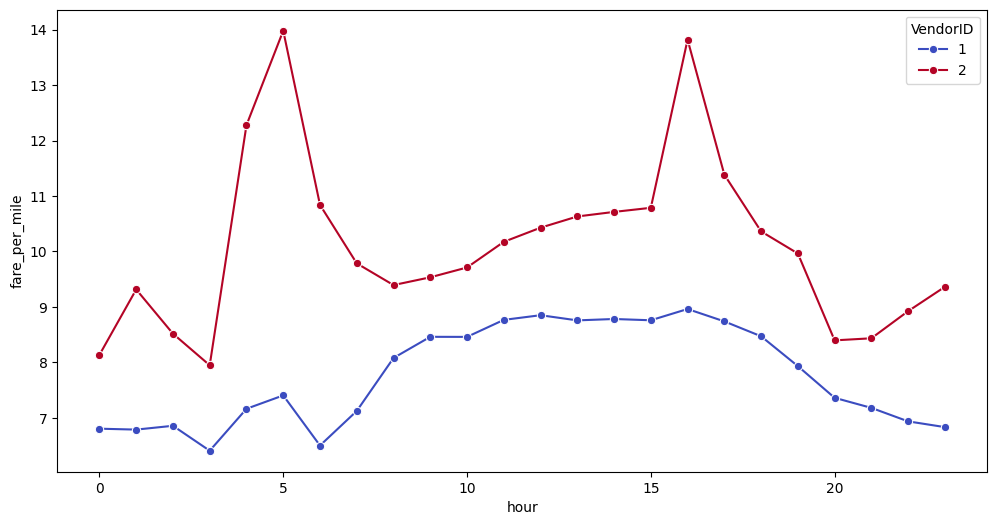

********* Vendor, hour wise Fare per fime average ***********
    VendorID  hour  fare_per_mile
0          1     0           6.81
1          1     1           6.79
2          1     2           6.86
3          1     3           6.41
4          1     4           7.16
5          1     5           7.41
6          1     6           6.50
7          1     7           7.12
8          1     8           8.08
9          1     9           8.46
10         1    10           8.46
11         1    11           8.77
12         1    12           8.85
13         1    13           8.76
14         1    14           8.78
15         1    15           8.76
16         1    16           8.96
17         1    17           8.74
18         1    18           8.47
19         1    19           7.93
20         1    20           7.36
21         1    21           7.18
22         1    22           6.94
23         1    23           6.83
24         2     0           8.14
25         2     1           9.32
26         2     2  

In [379]:
# Compare fare per mile for different vendors
fare_per_mile_per_vendor = merged_pickup_data.groupby(['VendorID','hour'])["fare_per_mile"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data = fare_per_mile_per_vendor, x = "hour", y = "fare_per_mile", hue = "VendorID", marker = "o", palette = "coolwarm")
plt.show()

print("********* Vendor, hour wise Fare per fime average ***********")
print(fare_per_mile_per_vendor)

print("\n")

print("********* Vendor wise Fare per fime average ***********")
print(merged_pickup_data.groupby('VendorID')["fare_per_mile"].mean())

<p style="font-size: 18px; font-weight: 500; color: blue"> 
The above vendor wise analysis shows that the vendor with ID 2 charges around 20% more than Vendor with ID 1.
</p>

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


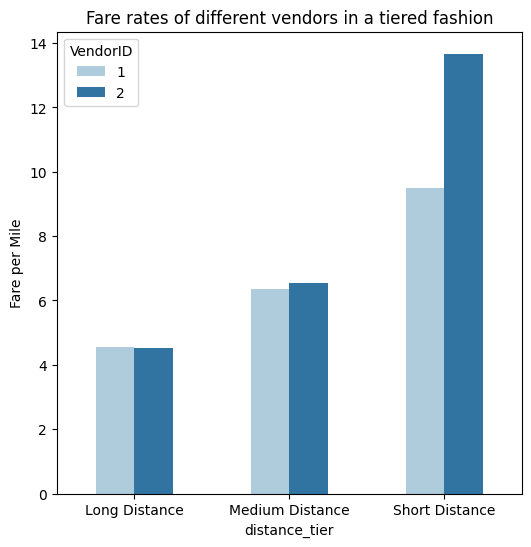

VendorID    distance_tier  fare_per_mile
0         1    Long Distance           4.55
3         2    Long Distance           4.51
1         1  Medium Distance           6.37
4         2  Medium Distance           6.54
2         1   Short Distance           9.50
5         2   Short Distance          13.67

In [383]:
# Defining distance tiers

def distance_tiers(distance):
    if distance <= 2:
        return "Short Distance"
    elif distance > 2 and distance <= 5:
        return "Medium Distance"
    else:
        return "Long Distance"

merged_pickup_data["distance_tier"] = merged_pickup_data["trip_distance"].apply(distance_tiers)

avg_fare_per_mile_distance_tier = merged_pickup_data.groupby(["VendorID", "distance_tier"])["fare_per_mile"].mean().reset_index()

plt.figure(figsize=(6, 6))
sns.barplot(data = avg_fare_per_mile_distance_tier, x = "distance_tier", y = "fare_per_mile", hue = "VendorID", palette = "Paired", width = .5)
plt.title("Fare rates of different vendors in a tiered fashion")
plt.ylabel("Fare per Mile")
plt.show()

avg_fare_per_mile_distance_tier.sort_values(by = "distance_tier")

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

*****  Average tip percentage by distance tiers *****
     distance_tier  tip_percentage
0    Long Distance           23.05
1  Medium Distance           23.04
2   Short Distance           28.76




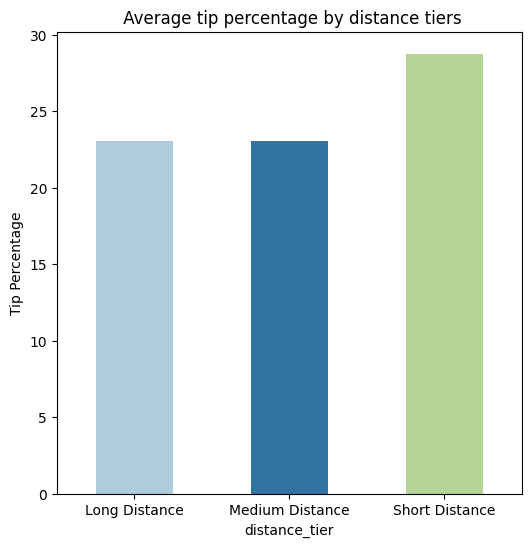

*****  Average tip percentage by passenger counts *****
   passenger_count  tip_percentage
0             1.00           26.37
1             2.00           25.84
2             3.00           25.84
3             4.00           25.92
4             5.00           26.04
5             6.00           26.18




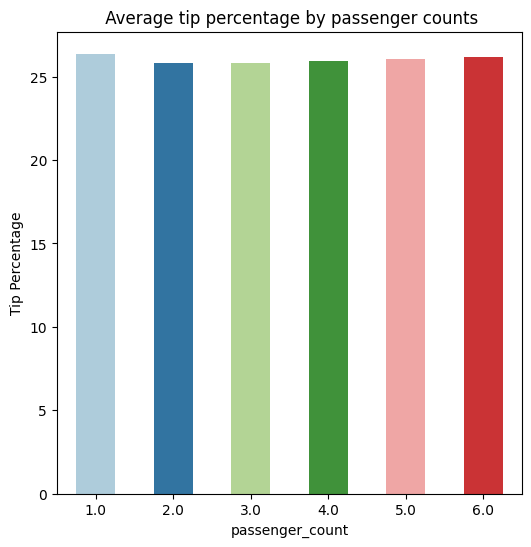

*****  Average tip percentage by hour *****
    hour  tip_percentage
0      0           25.75
1      1           26.03
2      2           26.39
3      3           27.30
4      4           26.50
5      5           25.54
6      6           24.95
7      7           24.79
8      8           24.82
9      9           25.16
10    10           25.47
11    11           25.44
12    12           25.34
13    13           25.37
14    14           25.13
15    15           24.96
16    16           27.13
17    17           30.88
18    18           27.51
19    19           27.40
20    20           26.42
21    21           26.21
22    22           25.95
23    23           25.69


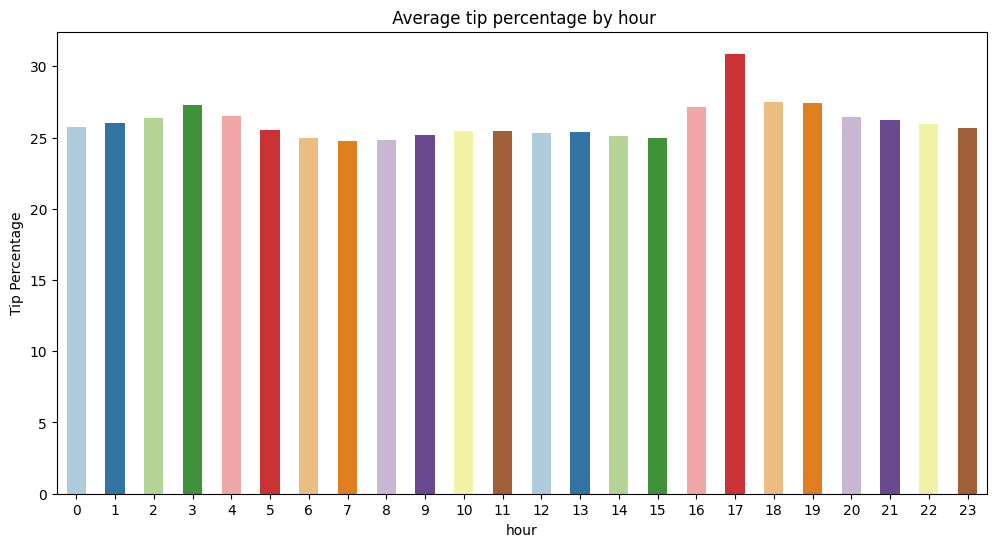

In [389]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

#Calculating tip percentage:
merged_pickup_data["tip_percentage"] = (merged_pickup_data["tip_amount"] / merged_pickup_data["fare_amount"]) * 100

# Grouping tip percentage by distance tiers

avg_tip_by_distance_tier = merged_pickup_data.groupby(["distance_tier"])["tip_percentage"].mean().reset_index()

print("*****  Average tip percentage by distance tiers *****")
print(avg_tip_by_distance_tier)
print("\n")

plt.figure(figsize=(6, 6))
sns.barplot(data = avg_tip_by_distance_tier, x = "distance_tier", y = "tip_percentage", palette = "Paired", width = .5)
plt.title(" Average tip percentage by distance tiers")
plt.ylabel("Tip Percentage")
plt.show()

# Grouping tip percentage by passenger counts

avg_tip_by_passenger_count = merged_pickup_data.groupby(["passenger_count"])["tip_percentage"].mean().reset_index()
print("*****  Average tip percentage by passenger counts *****")
print(avg_tip_by_passenger_count)
print("\n")

plt.figure(figsize=(6, 6))
sns.barplot(data = avg_tip_by_passenger_count, x = "passenger_count", y = "tip_percentage", palette = "Paired", width = .5)
plt.title(" Average tip percentage by passenger counts")
plt.ylabel("Tip Percentage")
plt.show()

# Grouping tip percentage by hour
avg_tip_by_hour = merged_pickup_data.groupby(["hour"])["tip_percentage"].mean().reset_index()

print("*****  Average tip percentage by hour *****")
print(avg_tip_by_hour)


plt.figure(figsize=(12, 6))
sns.barplot(data = avg_tip_by_hour, x = "hour", y = "tip_percentage", palette = "Paired", width = .5)
plt.title(" Average tip percentage by hour")
plt.ylabel("Tip Percentage")
plt.show()

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Factors that lead to low tip percentages are:
</p>

- Larger groups of passengers tip slightly less.
- Medium & long diatnce trips have slightly low tip percentage, passengers may be tipping low for high fare longer trips

**General Analysis**
- Tip percentage is highest in the evening hours (5 PM - 7 PM).
- Single passengers tip the most
- Short distance trips receive higher tip percentages.

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

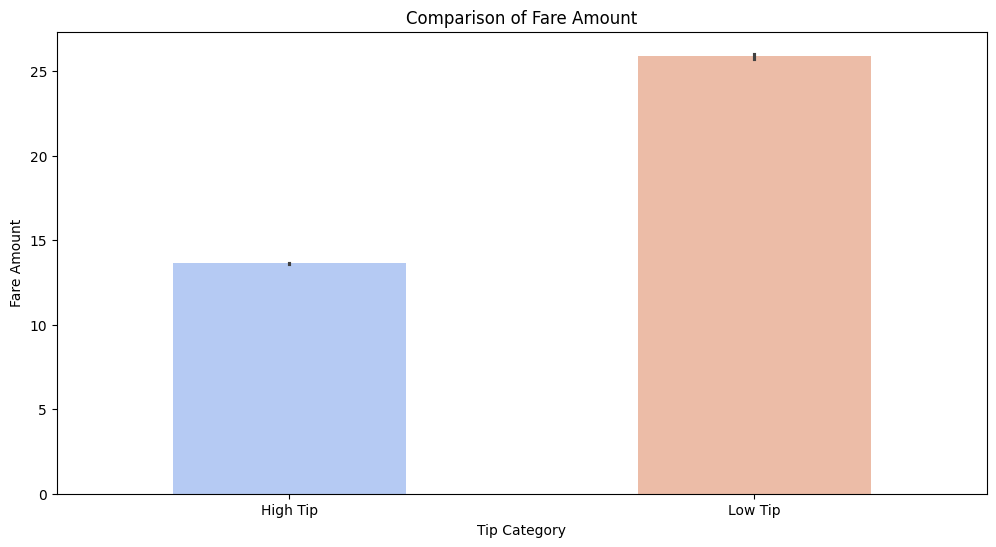

In [393]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

low_tip_trips = merged_pickup_data[merged_pickup_data["tip_percentage"] < 10]
high_tip_trips = merged_pickup_data[merged_pickup_data["tip_percentage"] > 25] 

merged_pickup_data["tip_category"] = merged_pickup_data["tip_percentage"].apply(lambda x: "Low Tip" if x < 10 else ("High Tip" if x > 25 else "Moderate Tip"))

filtered_tip_data = merged_pickup_data[merged_pickup_data["tip_category"].isin(["Low Tip", "High Tip"])]

# Plot tip percentage distribution for both groups
plt.figure(figsize=(12, 6))
sns.barplot(data = filtered_tip_data, x = "tip_category", y = "fare_amount", palette = "coolwarm", width = .5)
plt.title("Comparison of Fare Amount")
plt.xlabel("Tip Category")
plt.ylabel("Fare Amount")
plt.show()

In [395]:
# Ensure tip_category is encoded as numerical values
filtered_tip_data["tip_category_encoded"] = filtered_tip_data["tip_category"].astype("category").cat.codes
filtered_tip_data[["tip_category", "tip_category_encoded"]].head(20)

tip_category  tip_category_encoded
0      High Tip                     0
3      High Tip                     0
4      High Tip                     0
7      High Tip                     0
8      High Tip                     0
9      High Tip                     0
10     High Tip                     0
13     High Tip                     0
14     High Tip                     0
17      Low Tip                     1
19     High Tip                     0
22     High Tip                     0
25     High Tip                     0
26      Low Tip                     1
27     High Tip                     0
28     High Tip                     0
29     High Tip                     0
31      Low Tip                     1
32     High Tip                     0
34      Low Tip                     1

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

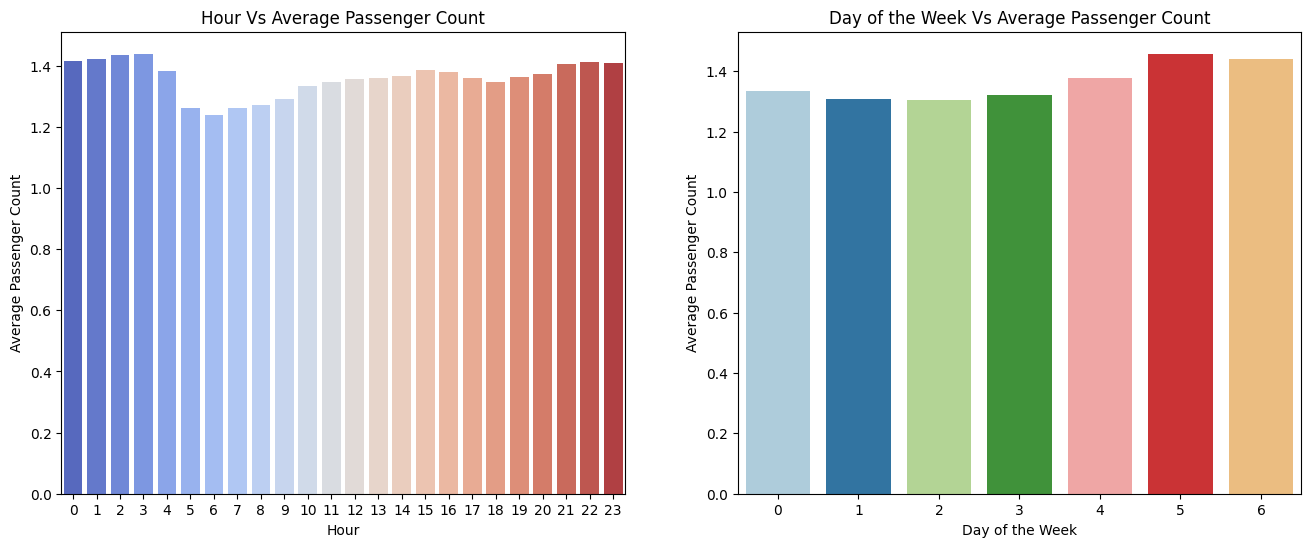

    hour  passenger_count
0      0             1.42
1      1             1.42
2      2             1.43
3      3             1.44
4      4             1.38
5      5             1.26
6      6             1.24
7      7             1.26
8      8             1.27
9      9             1.29
10    10             1.33
11    11             1.35
12    12             1.36
13    13             1.36
14    14             1.37
15    15             1.39
16    16             1.38
17    17             1.36
18    18             1.35
19    19             1.36
20    20             1.37
21    21             1.41
22    22             1.41
23    23             1.41
   pickup_day  passenger_count
0           0             1.34
1           1             1.31
2           2             1.31
3           3             1.32
4           4             1.38
5           5             1.46
6           6             1.44


In [398]:
# See how passenger count varies across hours and days

# Group by hour and average passenger count
avg_passenger_by_hour = merged_pickup_data.groupby("hour")["passenger_count"].mean().reset_index().sort_values(by="hour")

# Group by day of the week and average passenger count
avg_passenger_by_day = merged_pickup_data.groupby("pickup_day")["passenger_count"].mean().reset_index().sort_values(by="pickup_day")

# Bar chart
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data = avg_passenger_by_hour, x = "hour", y = "passenger_count", ax = ax[0], palette = "coolwarm")
ax[0].set_title("Hour Vs Average Passenger Count")
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Average Passenger Count")

#  Bar chart for fare per mile by hour of the day
sns.barplot(data = avg_passenger_by_day, x = "pickup_day", y = "passenger_count", ax = ax[1], palette = "Paired")
ax[1].set_title("Day of the Week Vs Average Passenger Count")
ax[1].set_xlabel("Day of the Week")
ax[1].set_ylabel("Average Passenger Count")

plt.show()

print(avg_passenger_by_hour)
print(avg_passenger_by_day)

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Analysis of passenger count across hours and days of the week.
</p>

- Passenger count increases late night
- Passenger count increases during weekend
- Evening trips has higher passenger counts
- Weekdays have more solo passengers

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

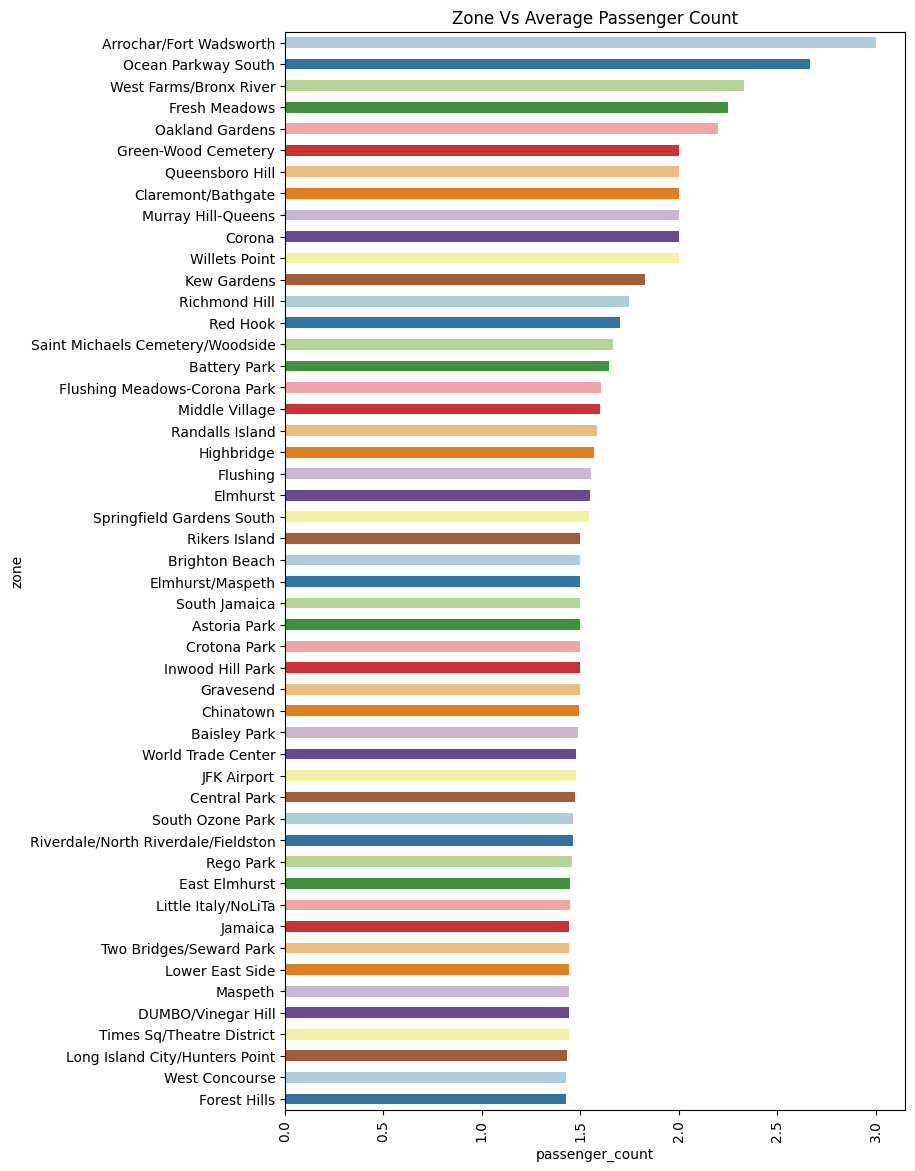

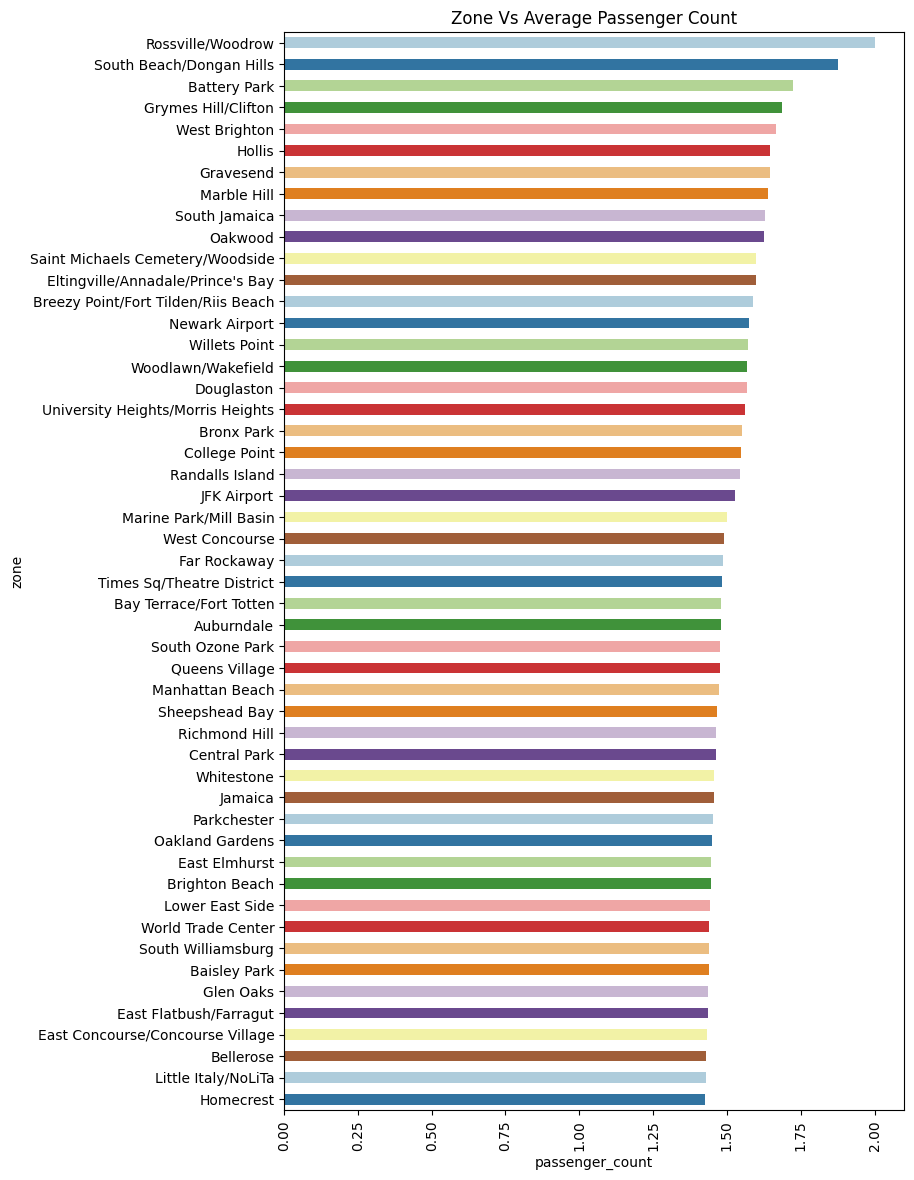

In [402]:
# How does passenger count vary across zones

# Group by zone and average passenger count
avg_passenger_by_zone = merged_pickup_data.groupby("zone")["passenger_count"].mean().reset_index().sort_values(by="passenger_count", ascending=False)
avg_passenger_by_dropoff_zone = merged_dropoff_data.groupby("zone")["passenger_count"].mean().reset_index().sort_values(by="passenger_count", ascending=False)

# Plotting top 50 zones as per average percentage count
plt.figure(figsize=(8, 14))
sns.barplot(data = avg_passenger_by_zone.head(50), y = "zone", x = "passenger_count", palette = "Paired", width = .5)
plt.title("Zone Vs Average Passenger Count")
plt.xticks(rotation = 90)
plt.show()

# Plotting top 50 zones as per average percentage count
plt.figure(figsize=(8, 14))
sns.barplot(data = avg_passenger_by_dropoff_zone.head(50), y= "zone", x = "passenger_count", palette = "Paired", width = .5)
plt.title("Zone Vs Average Passenger Count")
plt.xticks(rotation = 90)
plt.show()


In [403]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

avg_passenger_by_zone = avg_passenger_by_zone.reset_index().rename(columns={"passenger_count": "avg_passenger_count"})

# Merging into original dataframe to add avg_passenger_count column

merged_pickup_data = merged_pickup_data.merge(avg_passenger_by_zone, on="zone", how="left")

print(merged_pickup_data[["zone", "avg_passenger_count"]].head(10))

                        zone  avg_passenger_count
0             Midtown Center                 1.36
1         DUMBO/Vinegar Hill                 1.44
2  West Chelsea/Hudson Yards                 1.39
3               East Village                 1.39
4               East Village                 1.39
5                JFK Airport                 1.48
6            Lower East Side                 1.44
7               East Village                 1.39
8                   Flatiron                 1.34
9        Lincoln Square East                 1.37


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [408]:
# How often is each surcharge applied?

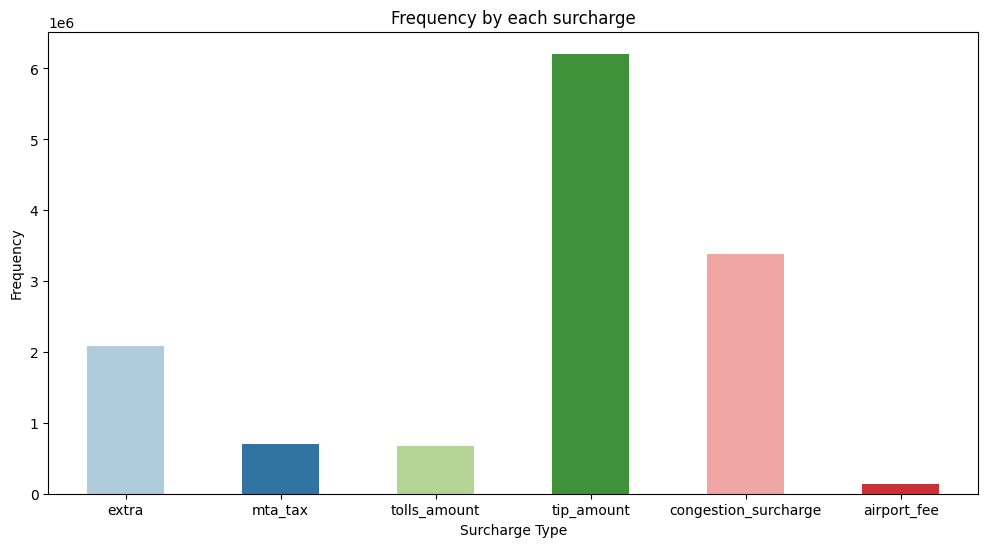

Surcharge Type  Frequency
3            tip_amount    6208921
4  congestion_surcharge    3375732
0                 extra    2080110
1               mta_tax     701085
2          tolls_amount     676004
5           airport_fee     135250

In [410]:
surcharge_counts = {
    "extra": round(merged_pickup_data["extra"].sum()),
    "mta_tax": round(merged_pickup_data["mta_tax"].sum()),
    "tolls_amount": round(merged_pickup_data["tolls_amount"].sum()),
    "tip_amount": round(merged_pickup_data["tip_amount"].sum()),
    "congestion_surcharge": round(merged_pickup_data["congestion_surcharge"].sum()),
    "airport_fee": round(merged_pickup_data["airport_fee"].sum())
}
surcharge_counts_df = pd.DataFrame(list(surcharge_counts.items()), columns=["Surcharge Type", "Frequency"])

plt.figure(figsize=(12, 6))
sns.barplot(data = surcharge_counts_df, x = "Surcharge Type", y = "Frequency", palette = "Paired", width = .5)
plt.title("Frequency by each surcharge")
plt.show()

surcharge_counts_df.sort_values(by = 'Frequency', ascending = False)

In [412]:
# Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [414]:
merged_pickup_data['total_extra_charges'] = (
    merged_pickup_data['extra'] + 
    merged_pickup_data['mta_tax'] +  
    merged_pickup_data['tip_amount'] +  
    merged_pickup_data['tolls_amount'] +  
    merged_pickup_data['improvement_surcharge'] +
    merged_pickup_data['airport_fee']
)

In [416]:
# Groupig Pickup zone with the sum of extra charges
extra_charge_by_pickup_zone = merged_pickup_data.groupby("PULocationID")["total_extra_charges"].sum().reset_index()

# Groupig dropoff zone with the sum of extra charges
extra_charge_by_dropoff_zone = merged_pickup_data.groupby("DOLocationID")["total_extra_charges"].sum().reset_index()

# Groupig hour with the sum of extra charges
extra_charge_by_hour = merged_pickup_data.groupby("hour")["total_extra_charges"].sum().reset_index()

# Merging with zone

extra_charge_by_pickup_zone = extra_charge_by_pickup_zone.merge(
    zones, left_on="PULocationID", right_on="LocationID", how="left"
).rename(columns={"zone": "Pickup Zone"})

extra_charge_by_dropoff_zone = extra_charge_by_dropoff_zone.merge(
    zones, left_on="DOLocationID", right_on="LocationID", how="left"
).rename(columns={"zone": "Dropoff Zone"})

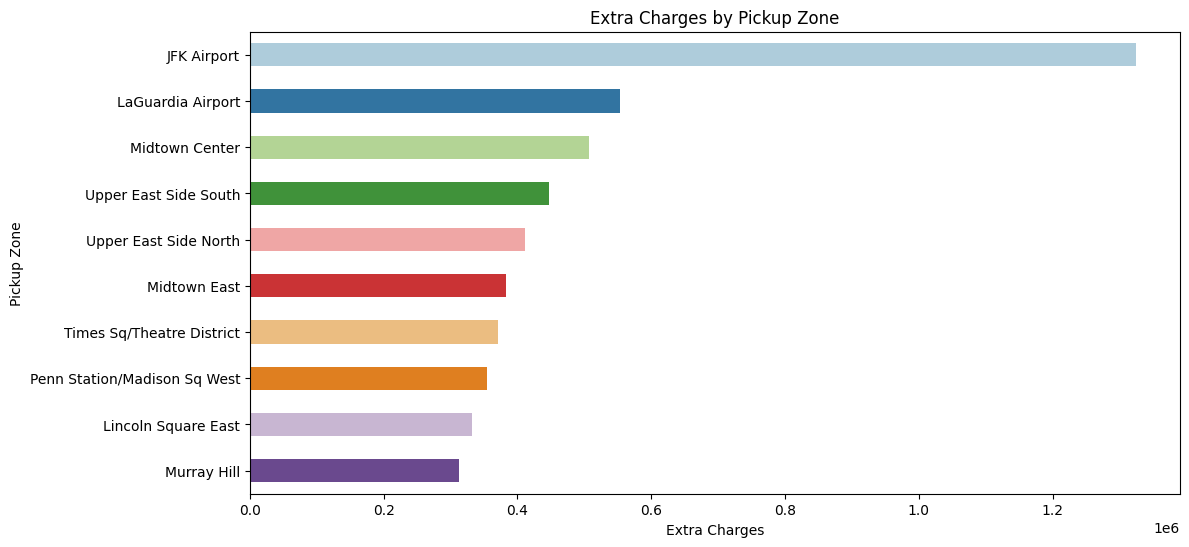

Pickup Zone    borough  total_extra_charges
113                   JFK Airport     Queens           1323974.19
119             LaGuardia Airport     Queens            553821.40
141                Midtown Center  Manhattan            507246.47
208         Upper East Side South  Manhattan            446521.34
207         Upper East Side North  Manhattan            411218.92
142                  Midtown East  Manhattan            382675.57
201     Times Sq/Theatre District  Manhattan            370111.65
163  Penn Station/Madison Sq West  Manhattan            354036.47
123           Lincoln Square East  Manhattan            332179.46
150                   Murray Hill  Manhattan            311963.22

In [418]:
# Extra Charges by Pickup Zone

top_ten_pickup_zones_by_extracharge = extra_charge_by_pickup_zone[["Pickup Zone","borough","total_extra_charges"]].sort_values(by="total_extra_charges", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data = top_ten_pickup_zones_by_extracharge, y = "Pickup Zone", x = "total_extra_charges", palette = "Paired", width = .5)
plt.title("Extra Charges by Pickup Zone")
plt.xlabel("Extra Charges")
plt.show()

top_ten_pickup_zones_by_extracharge


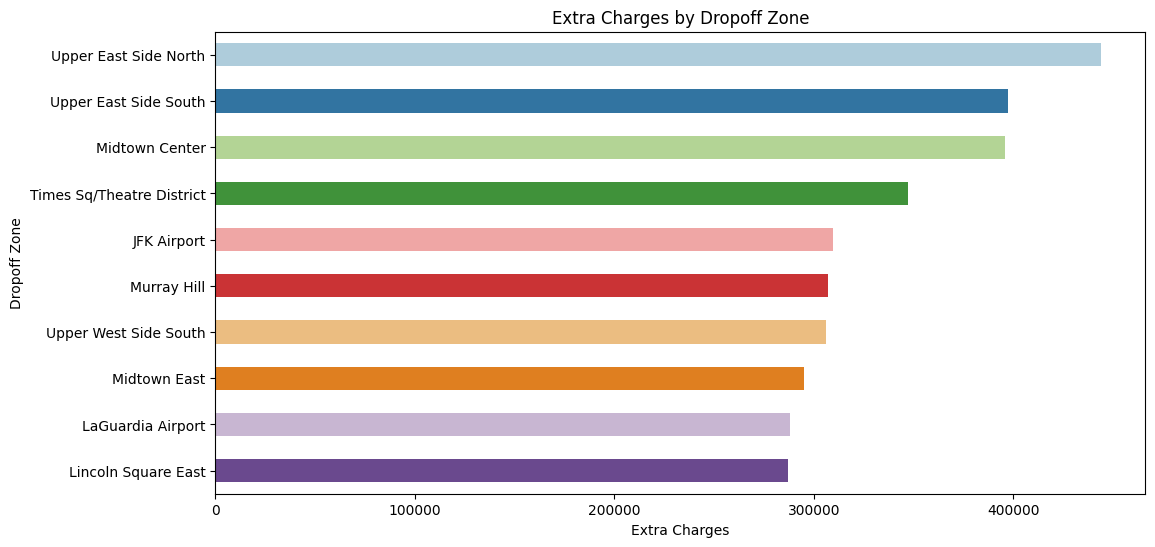

Dropoff Zone    borough  total_extra_charges
229      Upper East Side North  Manhattan            443852.91
230      Upper East Side South  Manhattan            397268.17
155             Midtown Center  Manhattan            395808.65
223  Times Sq/Theatre District  Manhattan            346897.32
126                JFK Airport     Queens            309603.94
164                Murray Hill  Manhattan            307109.50
232      Upper West Side South  Manhattan            305894.17
156               Midtown East  Manhattan            295177.68
132          LaGuardia Airport     Queens            287828.65
136        Lincoln Square East  Manhattan            287103.65

In [420]:
# Extra Charges by DropOff Zone

top_ten_dropff_zones_by_extracharge = extra_charge_by_dropoff_zone[["Dropoff Zone","borough","total_extra_charges"]].sort_values(by="total_extra_charges", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data = top_ten_dropff_zones_by_extracharge, y = "Dropoff Zone", x = "total_extra_charges", palette = "Paired", width = .5)
plt.title("Extra Charges by Dropoff Zone")
plt.xlabel("Extra Charges")
plt.show()

top_ten_dropff_zones_by_extracharge

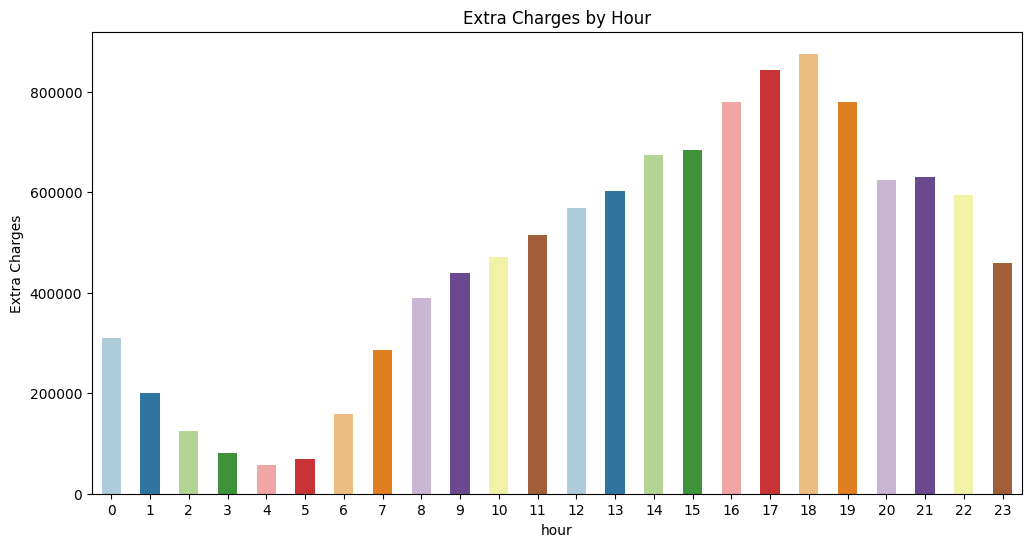

hour  total_extra_charges
0      0            309816.79
1      1            199666.19
2      2            125127.34
3      3             80622.53
4      4             57712.27
5      5             69568.45
6      6            157947.41
7      7            286300.09
8      8            389944.74
9      9            440076.80
10    10            470393.72
11    11            514637.48
12    12            568812.35
13    13            601987.12
14    14            672991.23
15    15            684583.15
16    16            778451.90
17    17            842528.60
18    18            875297.21
19    19            779466.44
20    20            623673.85
21    21            629796.58
22    22            593837.31
23    23            458142.38

In [422]:
plt.figure(figsize=(12, 6))
sns.barplot(data = extra_charge_by_hour, x = "hour", y = "total_extra_charges", palette = "Paired", width = .5)
plt.title("Extra Charges by Hour")
plt.ylabel("Extra Charges")
plt.show()

extra_charge_by_hour[["hour","total_extra_charges"]]

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Dispatching and Route optimizing can be done based on below points:
</p>

**Deploy more taxis in high-demand areas as below:**
- Upper East Side North 
- Upper East Side South
- Midtown Center 
- Midtown East
- JFK Airport
- Penn Station
- Lincoln Square
- Times Square 


**Increase cab availability at** 
- East Village and West Village in Manhattan during night hours
- Ensure a steady flow of taxis to JFK from 10 PM - 2 AM.

<p style="font-size: 18px; font-weight: 500; color: blue"> 
The operational inefficiencies can be improved using below approach:
</p>

- Dispatching can be improved by monitoring the historical and real-time data
- A demand prediction dashboard can be created using the AI models.
- By utilizing the dashboard, predictions can be made as to where the taxis will be in demand
- We can implement SMS notifications for drivers to alert them about the zones where taxis are in demand

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Suggestions on strategically positioning cabs during different times:
</p>

**1. High-Demand zones during early morning hours (12 AM - 6 AM)**

- JFK Airport
- Times Sq/Theatre District
- Penn Station/Madison Sq West
- Union Square

The taxis should be stationed in these areas more to cater the high demand during early morning hours

**2. High-Demand zones during morning hours (6 AM - 10 AM)**

- JFK Airport
- Upper East Side North & South
- Upper West Side
- Midtown Center
- Midtown East
- Penn Station/Madison Sq West
- Lincoln Square East
- Murray Hill

The taxis should be stationed in these areas more to cater to the high demand during morning hours

**3. High-Demand zones during mid day hours (10 AM - 4 PM)**

- Upper East Side North & South
- Midtown Center
- Midtown East
- JFK Airport
- Upper West Side
- Lincoln Square East

The taxis should be stationed in these areas more to cater to the high demand during mid day hours

**4. High-Demand zones during evening time (4 PM - 8 PM)**

- Midtown Center
- Upper East Side North & South
- Midtown East
- JFK Airport
- Lincoln Square East

The taxis should be stationed in these areas more to cater to the high demand during evening time

**5. High-Demand zones during night hours (8 PM - 12 AM)**

Midtown Center
JFK Airport
Times Sq/Theatre District
Upper East Side South
Lincoln Square East

The taxis should be stationed in these areas more to cater to the high demand during the night.

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Suggestions on strategically positioning cabs during different days:
</p>

|Day       |Zone |Borough | Trip Count |
|:---------|:-------------|:-------|:-----------|
|Monday | JFK Airport | Queens | 10264|
|Tuesday | Midtown Center | Manhattan | 12106|
|Wednesday | Midtown Center | Manhattan | 12789|
|Thursday | Upper East Side South | Manhattan | 12403|
|Friday | Upper East Side South | Manhattan | 10331|
|Saturday | East Village | Manhattan | 9277|
|Sunday | JFK Airport | Queens | 10743|


- As per the above data, these are the zones with the most demand on different days. The taxis should be positioned as per the demand in these zones

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Suggestions on strategically positioning cabs during different months:
</p>

|pickup_month | Max Trip Zone | Borough | trip_count|
|:---------|:-------------|:-------|:-----------|
| Jan | Upper East Side South | Manhattan | 5838|
| Feb | Upper East Side South | Manhattan | 5446|
| Mar | Midtown Center | Manhattan | 6318|
| Apr | Upper East Side South | Manhattan | 6048|
| May | Upper East Side South | Manhattan | 7001|
| Jun | Upper East Side South | Manhattan | 6083|
| Jul | Midtown Center | Manhattan | 5368|
| Aug | JFK Airport | Queens | 5095|
| Sep | Upper East Side South | Manhattan | 5284|
| Oct | Upper East Side South | Manhattan | 6568|
| Nov | Upper East Side South | Manhattan | 6834|
| Dec | Upper East Side South | Manhattan | 6549|

- As per the above data, these zones have the most demand on different months. The taxis should be positioned as per the demand in these zones

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

<p style="font-size: 18px; font-weight: 500; color: blue"> 
Pricing strategy points to maximize revenue are as follows:
</p>

- Fare can be increased during the peak hours (5-7 PM)
- Discount offers can be promoted for non-peak hours (3 AM - 6 AM) to attract more passengers.
- Vendor 1 can offer more competitive pricing as vendor 2 pricing is around 15% - 20% higher than vendor 1.